In [1]:
%%capture
!pip install xlrd
!pip install prophet
!pip install statsforecast
!pip install mlforecast
!pip install utilsforecast
!pip install tsfeatures
!pip install squarify

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Helper functions
def proc_datacleaning(filename = 'SPGlobal_Exports'):
    ''' The function checks if the cleaned data file exists.
    If not, it reads the raw data from an Excel file, processes it,
    and saves the cleaned data to a CSV file.

    parameters
    ----------
    filename : str
        The name of the file to check for cleaned data.

    returns
    -------
    None

    Note: Creates a cleaned CSV file if it does not exist.
    '''
    if not(os.path.exists(f'./data/{filename}_clean.csv')):
        DAT_Export = pd.read_excel(f'./data/{filename}.xls', skiprows=4)
        DAT_Export.dropna(axis=0, thresh=120, inplace=True)
        DAT_Export = DAT_Export.T.iloc[1:,:]
        DAT_Export.columns = DAT_Export.iloc[0,:].values

        DAT_Export = DAT_Export.iloc[1:,:]
        DAT_Export.reset_index(inplace=True)
        DAT_Export

        #create date series
        DAT_Export['ds'] = pd.date_range(start='1/1/2010',
                                          periods=DAT_Export.shape[0], freq='MS').sort_values(ascending=False)
        DAT_Export.drop(columns=['index'], inplace=True)
        DAT_Export.sort_values(by='ds',ascending=True).to_csv(f'./data/{filename}_clean.csv', index=False)

        print(f"Cleaned data saved to ./data/{filename}_clean.csv")

    return

def plot_series(df, time_col, target_col, ylabel, xlabel, color, title):
  df = df.set_index(time_col)
  df[target_col].plot(color=color)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.autoscale()
  plt.show()

## 1.0 Data Preprocessing (Cleaning)
Here we clean the downloaded data from S&P Global.

In [8]:
#proc_datacleaning(filename = 'SPGlobal_Exports')
#proc_datacleaning(filename = 'SPGlobal_Imports')

DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv', parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)
DAT_Export

DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)
#DAT_Import.pivot_table(index='ds', columns='unique_id', values='y').head()

## 2.0 Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from tsfeatures import *
from statsmodels.tsa.seasonal import STL
import time
from typing import List, Dict, Any

CONFIG = {
    'figure_size': (10, 4),
    'stl_figure_size': (10, 6),
    'seasonal_figure_size': (10, 5),
    'hist_figure_size': (10, 7),
    'stl_period': 4,
    'rolling_window': 4,
    'top_n_vars': 10,
    'selected_features': ['trend', 'seasonal_strength',
                          'e_acf1', 'e_acf10',
                          'x_acf1', 'x_acf10',
                          'entropy',],
    'selected_vars': ['USA','AUS','PHL','CHN','JPN']
}

class EDAPipeline:
    """
    A comprehensive pipeline for var production time series analysis and forecasting.
    """

    def __init__(self, config: Dict[str, Any] = CONFIG):
        self.config = config
        self.data = None
        self.features_data = None
        self.stl_results = {}

    def load_and_prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert wide format var data to long format for analysis.

        Parameters:
        -----------
        df : pd.DataFrame
            Wide format DataFrame with vars as columns and dates as index

        Returns:
        --------
        pd.DataFrame
            Long format DataFrame with columns: ds, unique_id, y
        """
        try:
            self.data = df.reset_index().melt(
                id_vars='ds',
                var_name='unique_id',
                value_name='y'
            )
            return self.data
        except Exception as e:
            print(f"Error in data preparation: {e}")
            return None

    def create_squareplot(self, df_slice: pd.DataFrame, title: str = "Square Plot of variables") -> None:
        """Create square plot visualization showing top N variables by share."""
        try:
            entry = df_slice.copy()
            entry.columns = ['val']
            entry.sort_values(by='val', ascending=False, inplace=True)
            entry['valz'] = entry['val'] / entry['val'].sum() * 100

            top_n = self.config['top_n_vars']
            labels = [
                f"{var}\n({pct:.2f}%)" if i < top_n else ""
                for i, (var, pct) in enumerate(zip(entry.index, entry['valz']))
            ]

            plt.figure(figsize=self.config['figure_size'])
            squarify.plot(
                sizes=entry['val'],
                label=labels,
                color=sns.color_palette("tab10", len(entry)),
                alpha=0.8
            )
            plt.axis('off')
            plt.title(title)
            plt.show()
        except Exception as e:
            print(f"Error creating squareplot: {e}")

    def extract_features(self, freq: int = 4) -> pd.DataFrame:
        """
        Extract comprehensive time series features from data.

        Parameters:
        -----------
        freq : int
            Frequency of the time series (4 for quarterly)

        Returns:
        --------
        pd.DataFrame
            DataFrame with extracted features
        """
        if self.data is None:
            print("Error: No data loaded. Call load_and_prepare_data first.")
            return None

        try:
            start_time = time.time()
            print("Extracting time series features...")

            all_features = [statistics, acf_features, stl_features, entropy, sparsity]
            self.features_data = tsfeatures(
                self.data,
                freq=freq,
                features=all_features,
                scale=False
            )

            print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")
            return self.features_data
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None

    def plot_feature_distributions(self, features: List[str] = None) -> None:
        """Plot histograms for selected features."""
        if self.features_data is None:
            print("Error: No features data available. Call extract_features first.")
            return

        features = features or self.config['selected_features']

        try:
            # Reshape data for plotting
            long_data = (self.features_data
                        .drop(columns=['nperiods', 'seasonal_period'], errors='ignore')
                        .melt(id_vars='unique_id', var_name='feature', value_name='value'))

            # Create subplots
            n_features = len(features)
            n_cols = 4
            n_rows = (n_features - 1) // n_cols + 1

            fig, axes = plt.subplots(n_rows, n_cols, figsize=self.config['hist_figure_size'])
            axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

            for i, feature in enumerate(features):
                if i < len(axes):
                    feature_data = long_data[long_data['feature'] == feature]['value']
                    sns.histplot(feature_data, kde=True, bins=30, ax=axes[i])
                    axes[i].set_title(feature)
                    axes[i].set_ylabel("Density")

            # Hide unused subplots
            for i in range(len(features), len(axes)):
                axes[i].set_visible(False)

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting feature distributions: {e}")

    def create_seasonal_plot(self, title: str = "Data by Cycle",
                           ylabel: str = "Value") -> None:
        """Create seasonal plots by quarter for all vars."""
        if self.data is None:
            print("Error: No data loaded.")
            return

        try:
            vars = self.data.copy()
            vars['ds'] = pd.to_datetime(vars['ds'])
            vars = vars.set_index('ds')
            vars['Quarter'] = vars.index.quarter
            vars['year'] = vars.index.year

            fig, axes = plt.subplots(1, 4, sharex=True, figsize=self.config['seasonal_figure_size'])
            quarters = sorted(vars["Quarter"].unique())

            for j, quarter in enumerate(quarters):
                quarter_data = vars[vars["Quarter"] == quarter]
                pivot_data = quarter_data.pivot_table(
                    index=quarter_data.index, columns='unique_id', values='y'
                )
                pivot_data.plot(ax=axes[j], legend=False, alpha=0.5)
                axes[j].set_title(f'Q{quarter}')
                axes[j].set_xlabel("")
                axes[j].tick_params(axis="x", rotation=90)
                axes[j].set_yscale("log")
                if quarter == 4:
                    axes[j].legend()

            fig.supylabel(ylabel, va="center", rotation=90)
            fig.supxlabel("Quarter", ha="center")
            fig.suptitle(title, fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating seasonal plot: {e}")

    def create_stl_decomposition(self, var_name: str) -> None:
        """
        Create STL decomposition plot for a specific var.

        Parameters:
        -----------
        var_name : str
            Name of the var to decompose
        """
        if self.data is None:
            print("Error: No data loaded.")
            return

        try:
            var_data = self.data[self.data['unique_id'] == var_name].copy()
            if var_data.empty:
                print(f"No data found for var: {var_name}")
                return

            # STL decomposition
            stl_result = STL(var_data['y'], period=self.config['stl_period'], robust=True).fit()

            # Prepare decomposition data
            decomp_data = pd.DataFrame({
                'ds': var_data["ds"].values,
                'data': var_data["y"].values,
                'trend': stl_result.trend,
                'seasonal': stl_result.seasonal,
                'resid': stl_result.resid
            }).set_index('ds')

            self.stl_results[var_name] = decomp_data

            # Create plots

            if var_name in self.config['selected_vars']:
                fig, axes = plt.subplots(4, 1,
                                        sharex=True,
                                        figsize=self.config['stl_figure_size'])

                # Plot components
                decomp_data['data'].plot(ax=axes[0])
                axes[0].set_title('Original')

                decomp_data['trend'].plot(ax=axes[1])
                axes[1].set_title('Trend')

                decomp_data['seasonal'].plot(ax=axes[2])
                axes[2].set_title('Seasonal')

                decomp_data['resid'].plot(ax=axes[3], alpha=0.6)
                decomp_data['resid'].plot(ax=axes[3], alpha=0.5)
                axes[3].set_title('Residual')

                # Add rolling variance to seasonal plot
                decomp_data['seasonal_sd'] = decomp_data['seasonal'].rolling(
                    window=self.config['rolling_window'], center=True
                ).std()

                ax2 = axes[2].twinx()
                decomp_data['seasonal_sd'].plot(ax=ax2, color='tab:orange')
                ax2.set_ylabel('Rolling SD', color='tab:orange')

                fig.suptitle(var_name, fontsize=12)
                plt.tight_layout()
                plt.show()

                #save stl_result to .self

        except Exception as e:
            print(f"Error creating STL decomposition for {var_name}: {e}")

    def run_analysis_pipeline(self, df: pd.DataFrame, create_visualizations: bool = True) -> None:
        """
        Run the complete analysis pipeline.

        Parameters:
        -----------
        df : pd.DataFrame
            Input crop production data
        create_visualizations : bool
            Whether to create all visualizations
        """
        print("=" * 50)
        print("ANALYSIS PIPELINE")
        print("=" * 50)

        # Step 1: Data preparation
        print("\n1. Preparing data...")
        self.load_and_prepare_data(df)

        # Step 2: Feature extraction
        print("\n2. Extracting features...")
        self.extract_features()

        if create_visualizations:
            # Step 3: Basic visualizations
            print("\n3. Creating overview visualizations...")
            latest_data = df.iloc[-1].to_frame()

            self.create_squareplot(latest_data)

            # Step 4: Feature analysis
            print("\n4. Analyzing feature distributions...")
            self.plot_feature_distributions()

            # Step 5: Seasonal analysis
            print("\n5. Creating seasonal plots...")
            self.create_seasonal_plot()

            # Step 6: STL decomposition for selected vars
            print("\n6. Creating STL decompositions...")
            for var in df.columns: #self.config['selected_vars']:
                print(f"   - Decomposing {var}")
                self.create_stl_decomposition(var)

        print("\n" + "=" * 50)
        print("ANALYSIS COMPLETE")
        print("=" * 50)


#### (a) EDA Export Volume

ANALYSIS PIPELINE

1. Preparing data...

2. Extracting features...
Extracting time series features...
Feature extraction completed in 10.68 seconds

3. Creating overview visualizations...


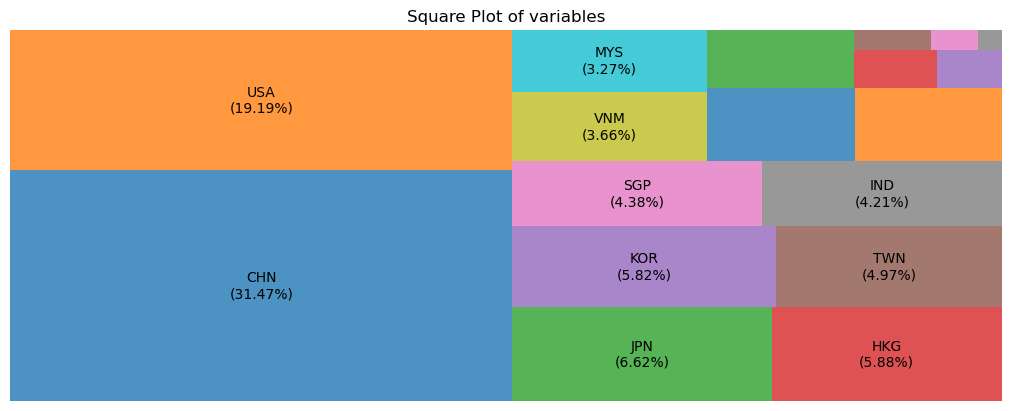


4. Analyzing feature distributions...


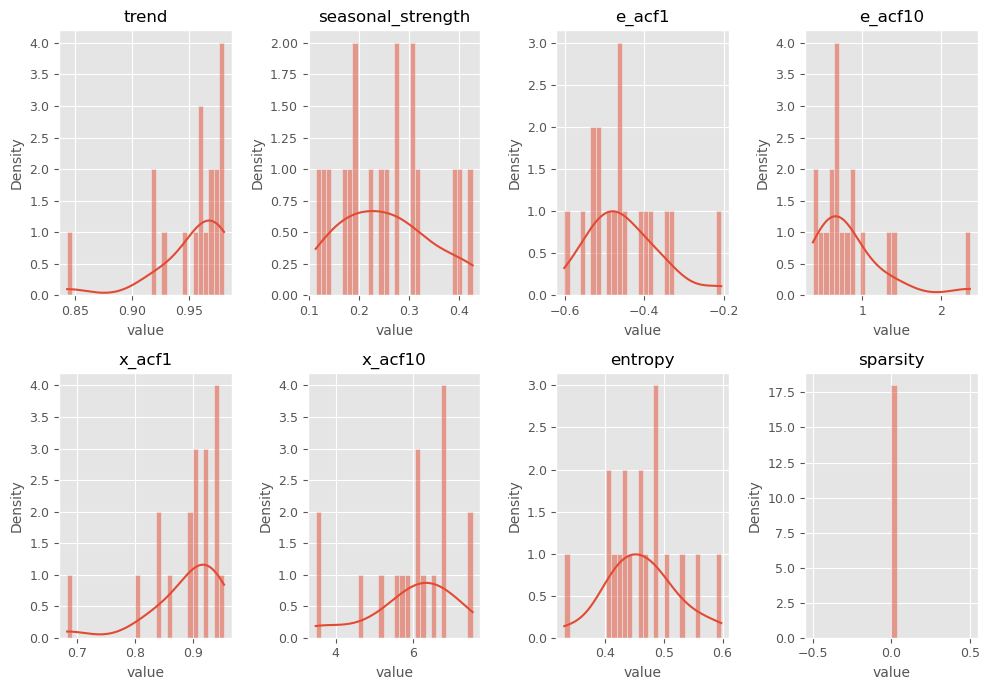


5. Creating seasonal plots...


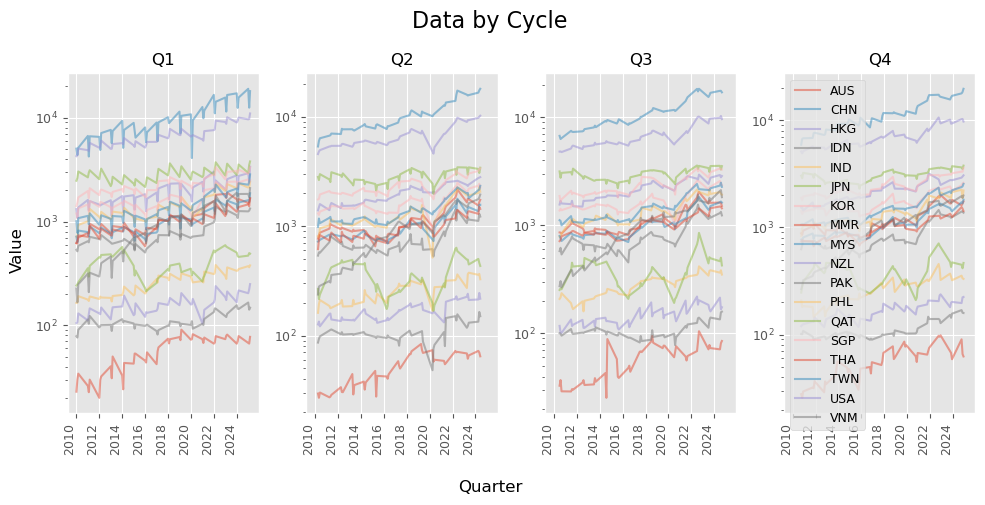


6. Creating STL decompositions...
   - Decomposing AUS


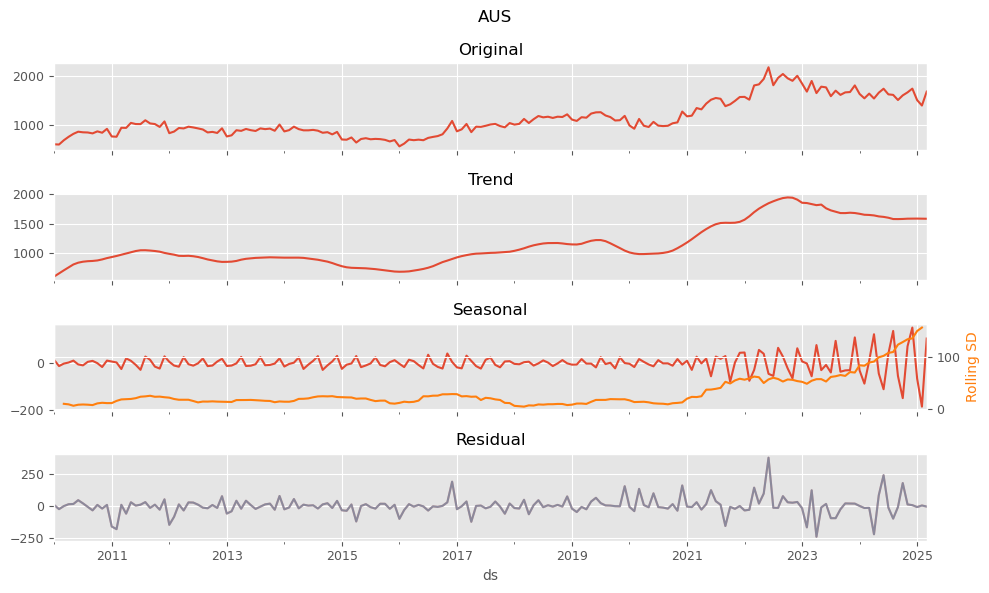

   - Decomposing CHN


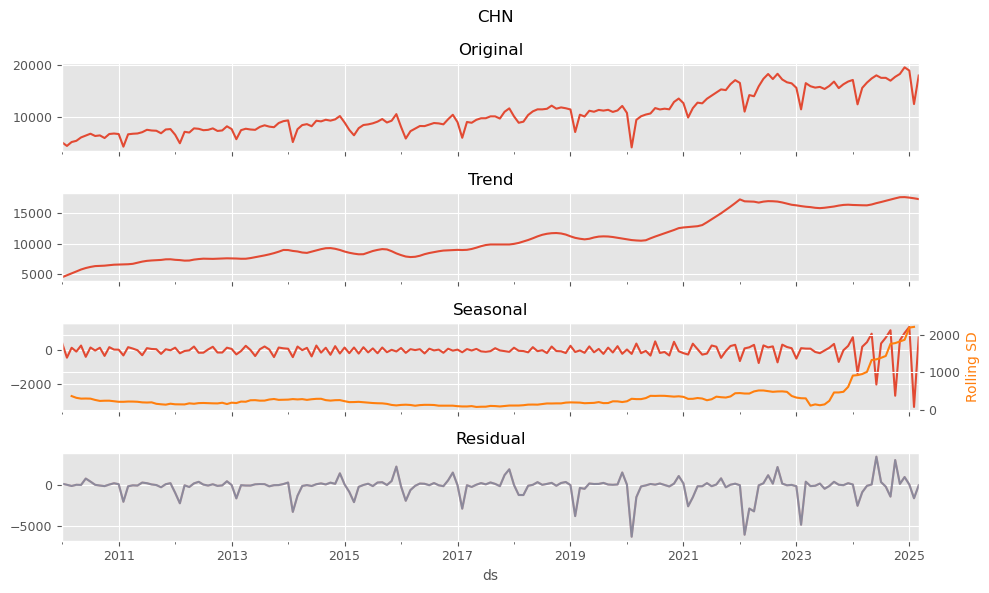

   - Decomposing HKG
   - Decomposing IDN
   - Decomposing IND
   - Decomposing JPN


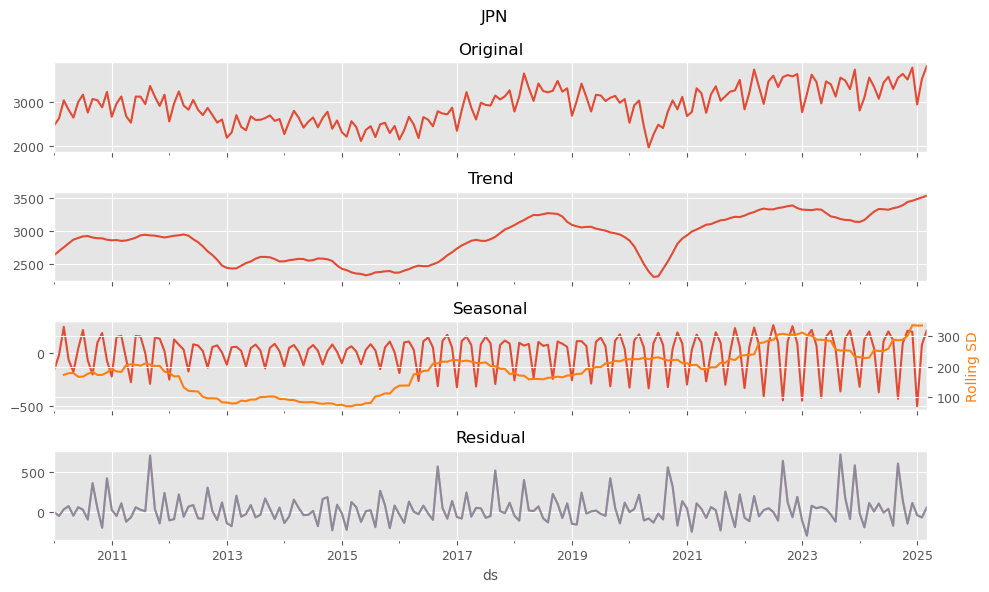

   - Decomposing KOR
   - Decomposing MMR
   - Decomposing MYS
   - Decomposing NZL
   - Decomposing PAK
   - Decomposing PHL


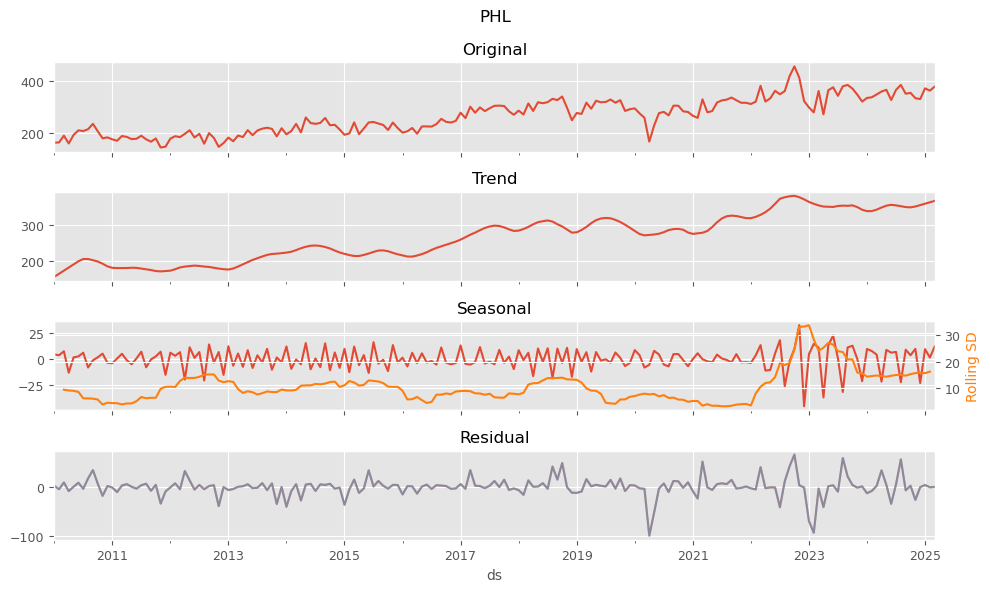

   - Decomposing QAT
   - Decomposing SGP
   - Decomposing THA
   - Decomposing TWN
   - Decomposing USA


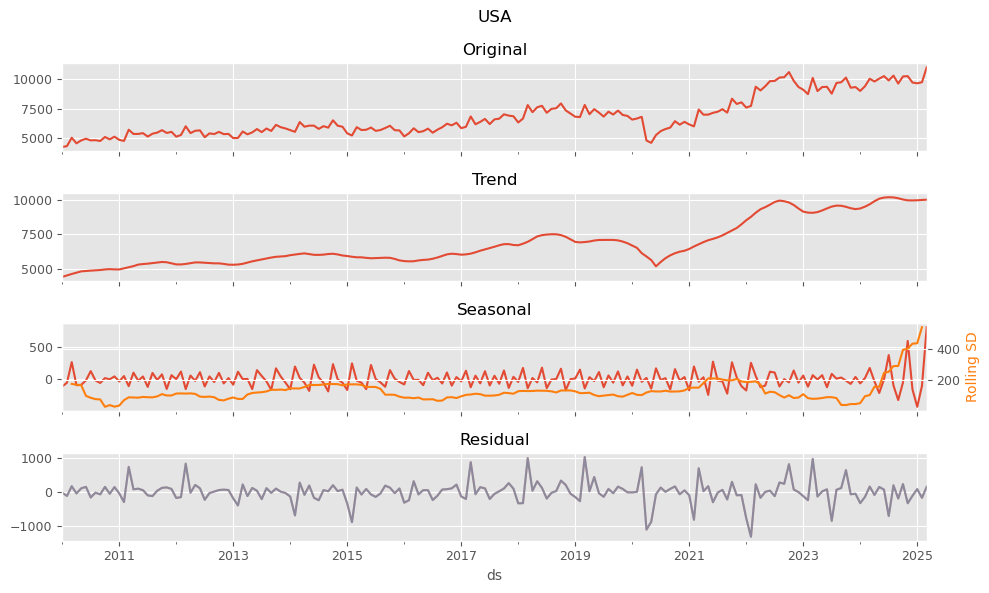

   - Decomposing VNM

ANALYSIS COMPLETE


In [ ]:
pipeline_export = EDAPipeline()
# Run complete analysis
pipeline_export.run_analysis_pipeline(DAT_Export.pivot_table(index='ds', columns='unique_id', values='y')
                                       , create_visualizations=True)

In [ ]:
pipeline_export.stl_results

{'AUS':                 data     trend  seasonal   resid  seasonal_sd
 ds                                                           
 2010-01-01   618.538   597.581    12.970   7.987          NaN
 2010-02-01   613.971   650.563   -12.922 -23.670          NaN
 2010-03-01   699.770   702.345    -2.460  -0.115       10.745
 2010-04-01   769.386   752.676     2.261  14.449        9.723
 2010-05-01   829.484   802.715    10.363  16.406        7.045
 ...              ...       ...       ...     ...          ...
 2024-11-01  1667.161  1582.519    71.773  12.869      133.719
 2024-12-01  1743.023  1584.089   151.677   7.258      135.417
 2025-01-01  1510.415  1584.018   -66.146  -7.458      149.487
 2025-02-01  1401.243  1582.962  -186.326   4.608      156.061
 2025-03-01  1682.214  1581.336   104.738  -3.859          NaN
 
 [183 rows x 5 columns],
 'CHN':                  data      trend  seasonal     resid  seasonal_sd
 ds                                                               
 2010-

#### Insights:

#### (b) EDA Import Volume

ANALYSIS PIPELINE

1. Preparing data...

2. Extracting features...
Extracting time series features...
Feature extraction completed in 10.97 seconds

3. Creating overview visualizations...


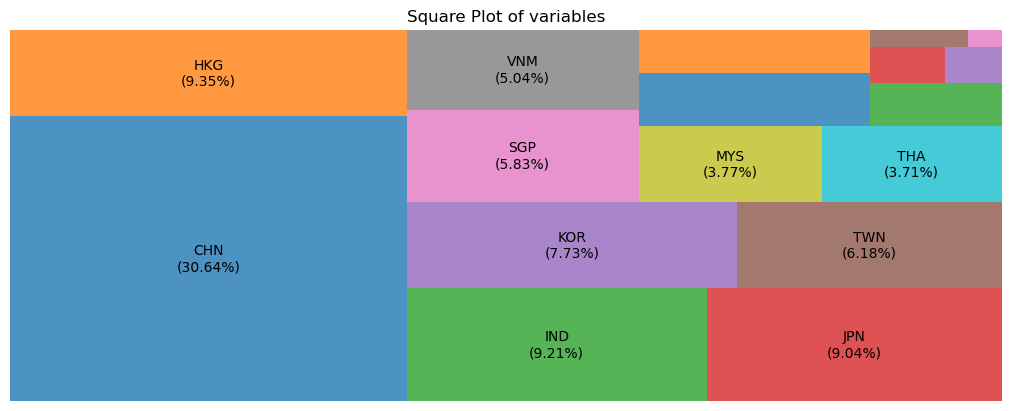


4. Analyzing feature distributions...


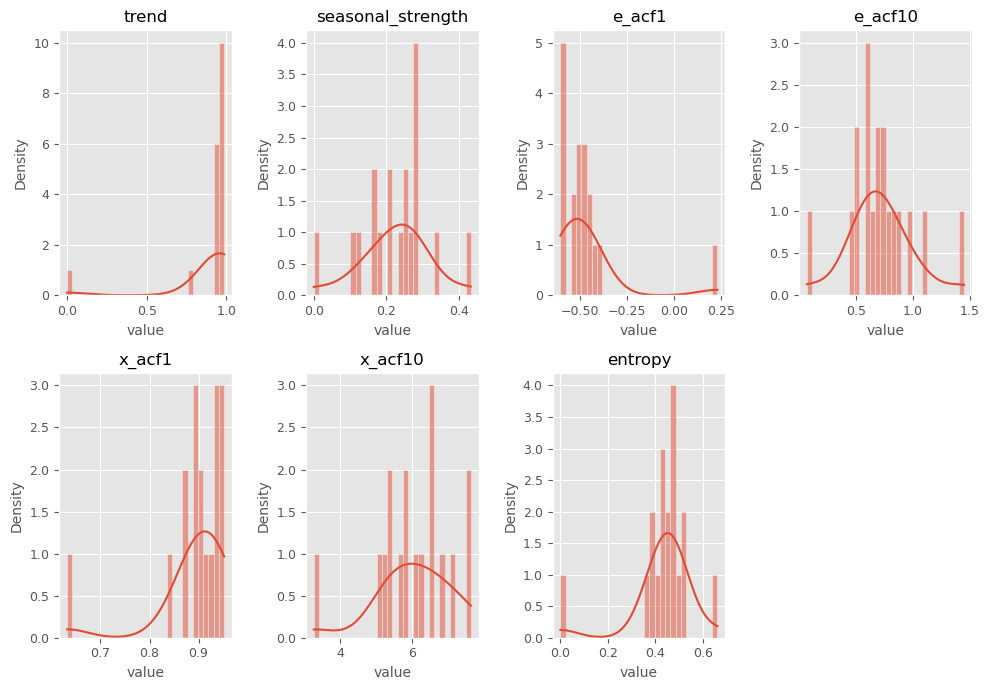


5. Creating seasonal plots...


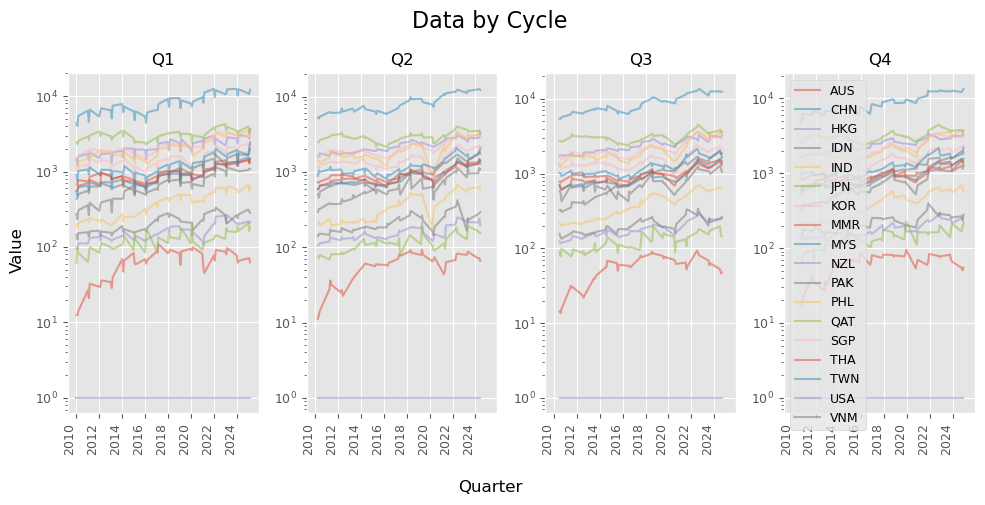


6. Creating STL decompositions...
   - Decomposing AUS


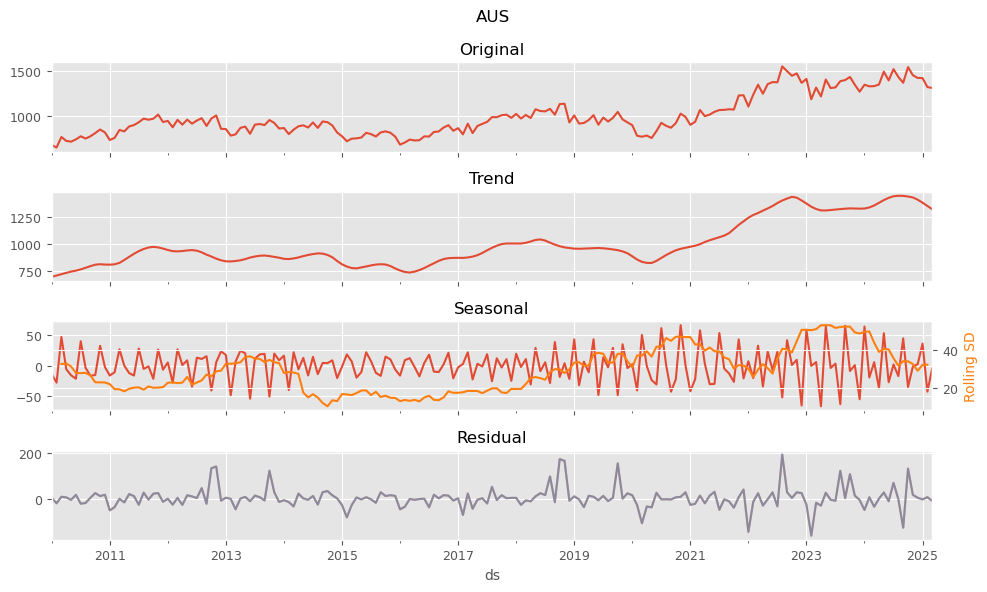

   - Decomposing CHN


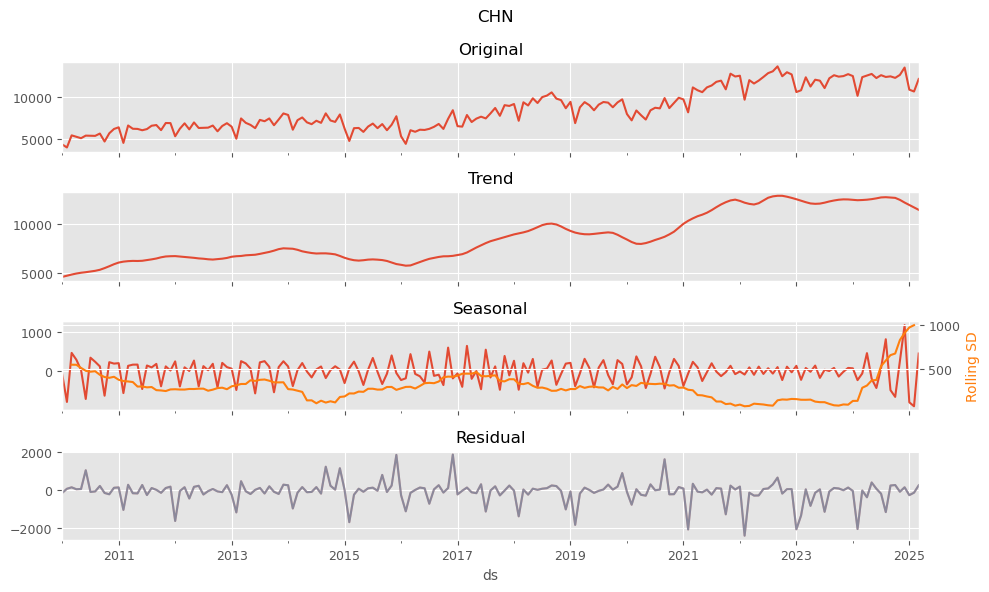

   - Decomposing HKG
   - Decomposing IDN
   - Decomposing IND
   - Decomposing JPN


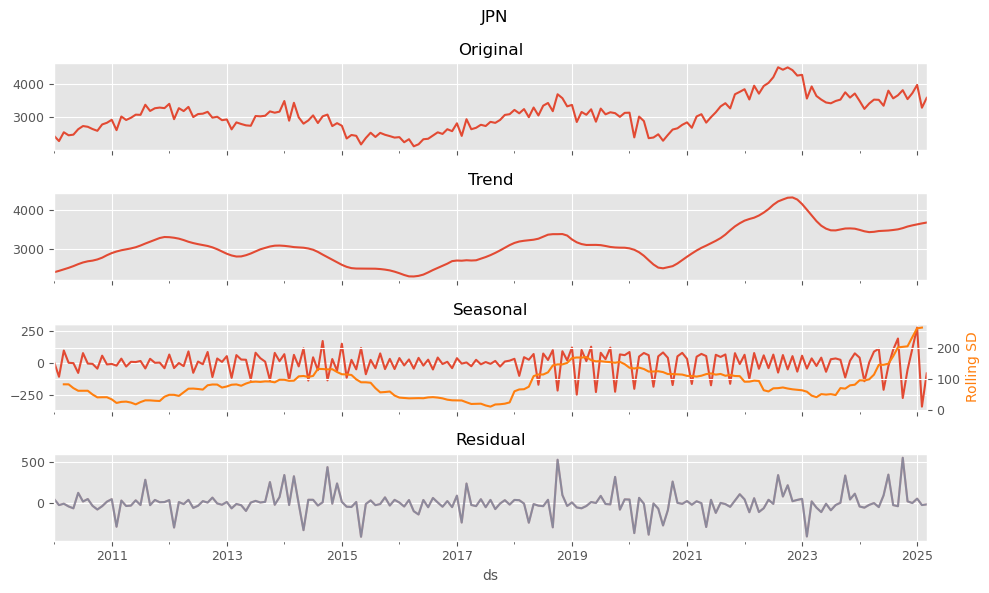

   - Decomposing KOR
   - Decomposing MMR
   - Decomposing MYS
   - Decomposing NZL
   - Decomposing PAK
   - Decomposing PHL


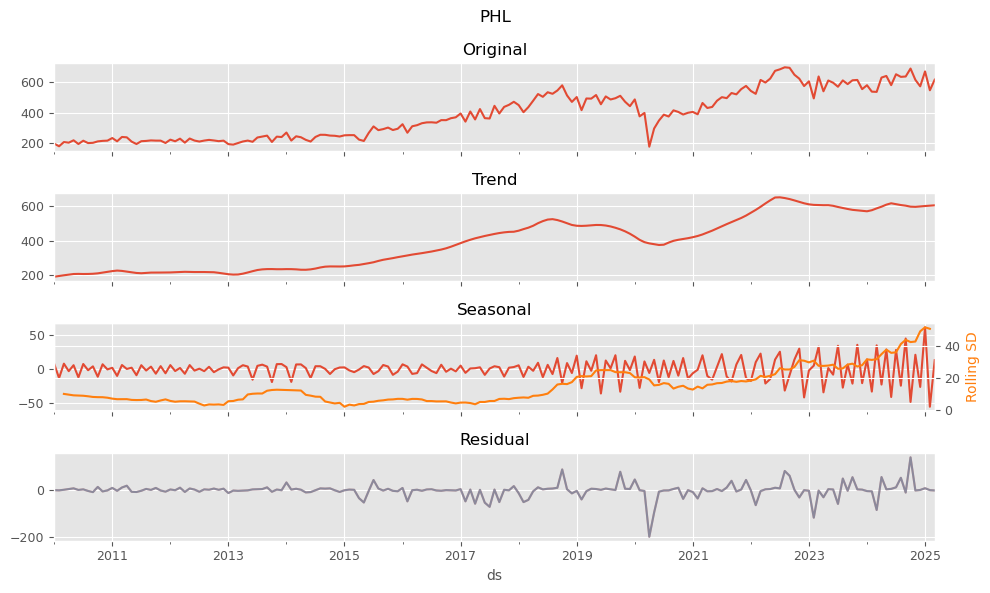

   - Decomposing QAT
   - Decomposing SGP
   - Decomposing THA
   - Decomposing TWN
   - Decomposing USA


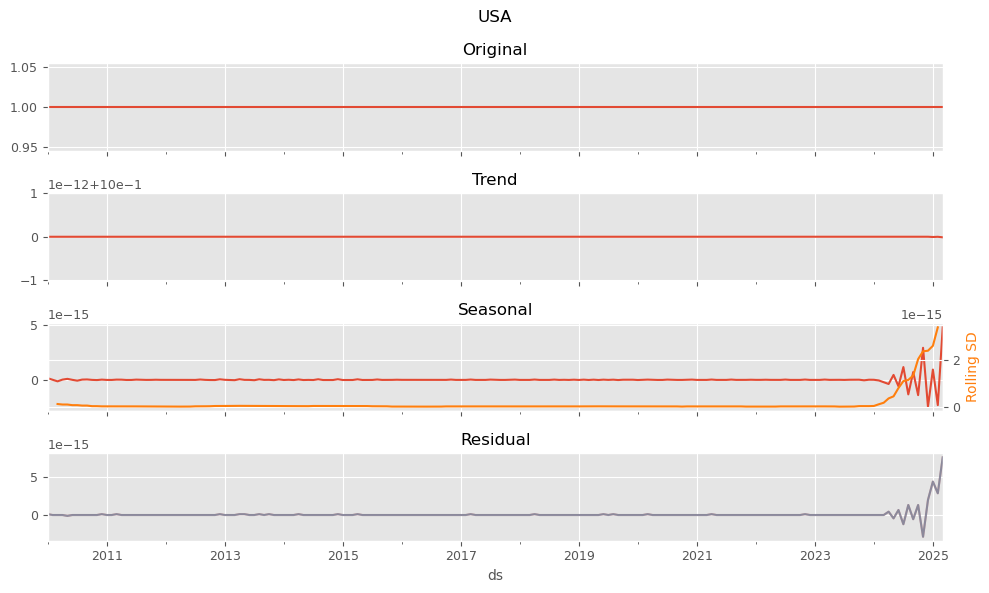

   - Decomposing VNM

ANALYSIS COMPLETE


In [ ]:
pipeline_import = EDAPipeline()
# Run complete analysis
pipeline_import.run_analysis_pipeline(DAT_Import.pivot_table(index='ds', columns='unique_id', values='y')
                                       , create_visualizations=True)

#### Insights:

## 3.0 TS Features (TSF)

### (a) TSF Exports

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 4) Processing feature_extractor, total=   8.9s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s


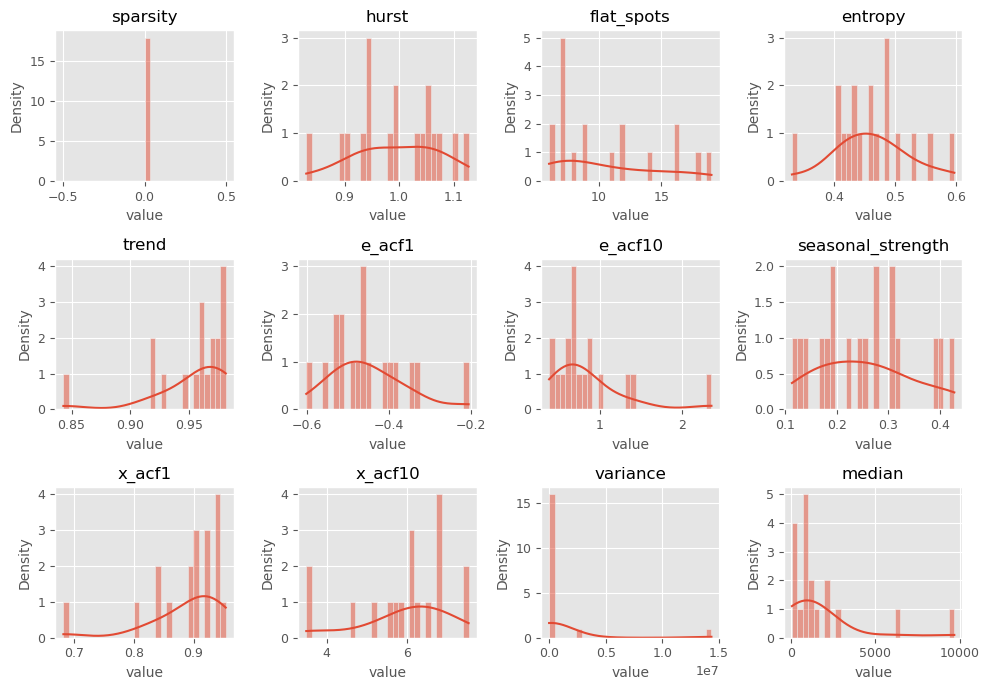

[Pipeline] ........ (step 4 of 4) Processing visualizer, total=   1.5s
Pipeline steps:
- preprocessor: TimeSeriesDataPreprocessor
- feature_extractor: TimeSeriesFeatureExtractor
- feature_selector: FeatureSelector
- visualizer: FeatureVisualizer


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from tsfeatures import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class TimeSeriesDataPreprocessor(BaseEstimator, TransformerMixin):
    """Convert wide format crop data to long format for tsfeatures."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Transform wide format DataFrame to long format."""
        if isinstance(X, pd.DataFrame):
            long_data = (X.melt(ignore_index=False)
                        .reset_index()
                        .rename(columns={'index': 'ds',
                                       'variable': 'unique_id',
                                       'value': 'y'}))
            return long_data
        else:
            raise ValueError("Input must be a pandas DataFrame")

class TimeSeriesFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract comprehensive time series features."""

    def __init__(self, freq=4, features=None, scale=False):
        self.freq = freq
        self.scale = scale
        self.features = features or [
            statistics,
            acf_features,
            stl_features,
            crossing_points,
            entropy,
            flat_spots,
            lumpiness,
            stability,
            hurst,
            sparsity,
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Extract time series features."""
        features_df = tsfeatures(
            X,
            freq=self.freq,
            features=self.features,
            scale=self.scale
        )
        return features_df

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Select specific features and reshape to long format."""

    def __init__(self, selected_features=None):
        self.selected_features = selected_features or [
            'trend', 'seasonal_strength',
            'e_acf1', 'e_acf10',
            'x_acf1', 'x_acf10',
            'flat_spots', 'sparsity',
            'entropy', 'hurst',
            'median', 'variance'
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Select features and convert to long format."""
        # Drop metadata columns
        features_clean = X.drop(columns=['nperiods', 'seasonal_period'], errors='ignore')

        # Convert to long format
        long_data = features_clean.melt(
            id_vars='unique_id',
            var_name='feature',
            value_name='value'
        )

        # Filter selected features
        if self.selected_features:
            long_data = long_data[long_data['feature'].isin(self.selected_features)]

        return long_data

class FeatureVisualizer(BaseEstimator, TransformerMixin):
    """Visualize feature distributions."""

    def __init__(self, figsize=(10, 7), n_cols=4):
        self.figsize = figsize
        self.n_cols = n_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Create feature distribution plots and return data unchanged."""
        features = X['feature'].unique()
        n_features = len(features)
        n_rows = (n_features - 1) // self.n_cols + 1

        fig, axes = plt.subplots(n_rows, self.n_cols, figsize=self.figsize)
        axes = axes.flatten() if n_rows > 1 else [axes] if self.n_cols == 1 else axes

        for i, feature in enumerate(features):
            if i < len(axes):
                feature_data = X[X['feature'] == feature]['value']
                sns.histplot(feature_data, kde=True, bins=30, ax=axes[i])
                axes[i].set_title(f"{feature}")
                axes[i].set_ylabel("Density")

        # Hide unused subplots
        for i in range(len(features), len(axes)):
            if i < len(axes):
                axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        return X

# Create the pipeline
ts_feature_EXPORT = Pipeline([
    ('preprocessor', TimeSeriesDataPreprocessor()),
    ('feature_extractor', TimeSeriesFeatureExtractor(freq=4)),
    ('feature_selector', FeatureSelector()),
    ('visualizer', FeatureVisualizer())
], verbose=True)

# Usage example:
# Fit and transform the data
df = DAT_Export.pivot_table(index='ds', columns='unique_id', values='y')
long_features = ts_feature_EXPORT.fit_transform(df)

# Access pipeline components
print("Pipeline steps:")
for name, step in ts_feature_EXPORT.named_steps.items():
    print(f"- {name}: {type(step).__name__}")

# Access intermediate results
# preprocessed_data = ts_feature_EXPORT.named_steps['preprocessor'].transform(df)
# features_only = ts_feature_EXPORT.named_steps['feature_extractor'].transform(preprocessed_data)

# print(f"\nFeatures extracted: {features_only.shape}")
# print(f"Long format data: {long_features.shape}")


### (b) TSF Imports

[Pipeline] ...... (step 1 of 4) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 4) Processing feature_extractor, total=   8.5s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s


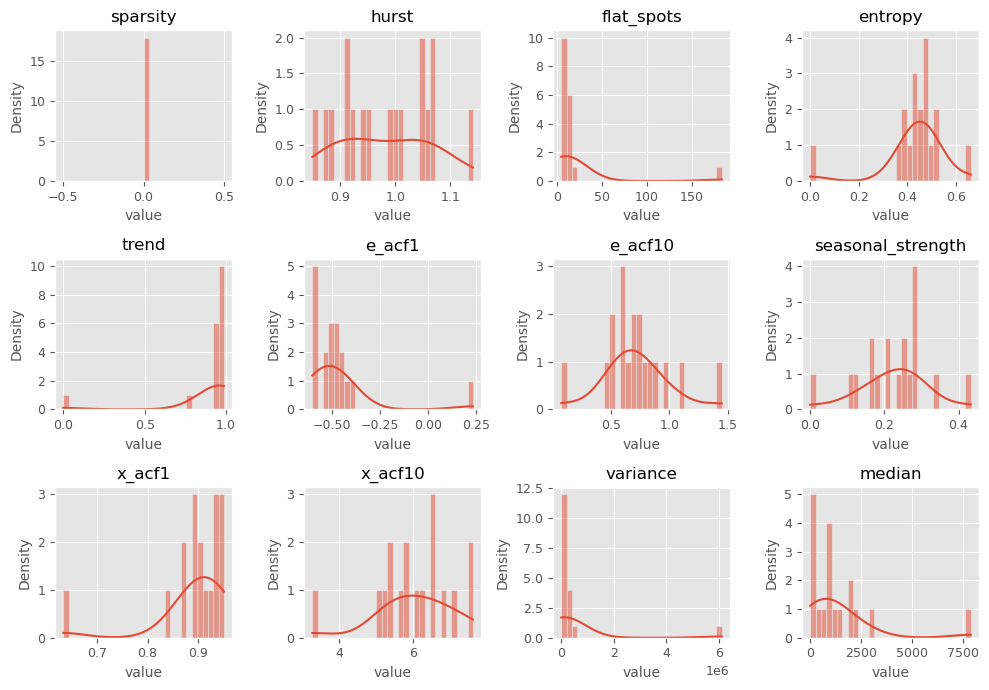

[Pipeline] ........ (step 4 of 4) Processing visualizer, total=   1.6s
Pipeline steps:
- preprocessor: TimeSeriesDataPreprocessor
- feature_extractor: TimeSeriesFeatureExtractor
- feature_selector: FeatureSelector
- visualizer: FeatureVisualizer


In [ ]:
# Create the pipeline
ts_feature_IMPORT = Pipeline([
    ('preprocessor', TimeSeriesDataPreprocessor()),
    ('feature_extractor', TimeSeriesFeatureExtractor(freq=4)),
    ('feature_selector', FeatureSelector()),
    ('visualizer', FeatureVisualizer())
], verbose=True)

# Usage example:
# Fit and transform the data
df = DAT_Import.pivot_table(index='ds', columns='unique_id', values='y')
long_features = ts_feature_IMPORT.fit_transform(df)

# Access pipeline components
print("Pipeline steps:")
for name, step in ts_feature_IMPORT.named_steps.items():
    print(f"- {name}: {type(step).__name__}")

## 4. Outlier Detection

### (a) Outlier Export

Starting PCA-based Outlier Detection Pipeline
1. Preparing features for PCA analysis...
2. Standardizing features...
3. Performing PCA transformation...
4. Identifying top 5 outliers...

 PCA Analysis Results:
------------------------------
PCA Explained Variance:


,Component,Explained_Variance_Ratio,Cumulative_Variance_Ratio
0,PC1,0.581,0.581
1,PC2,0.201,0.782
2,PC3,0.119,0.901
3,PC4,0.065,0.966
4,PC5,0.029,0.995



Top 5 Outlier var (by PC1):


,unique_id,PC1,PC2
5,JPN,5.649,2.969
9,NZL,3.733,-2.426
10,PAK,1.631,-0.180
2,HKG,1.464,-0.779
7,MMR,0.359,-0.761



📈 Creating PCA scatter plot...


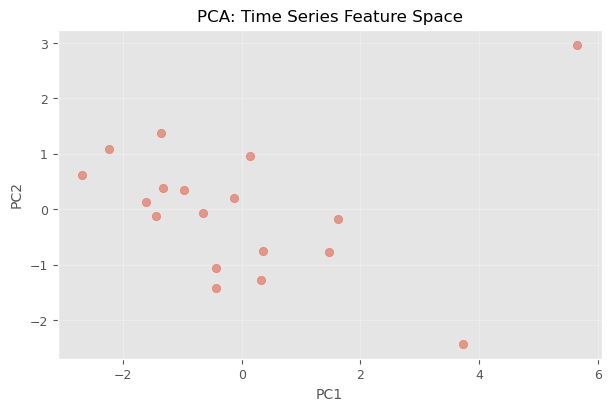


📈 Plotting outlier time series...


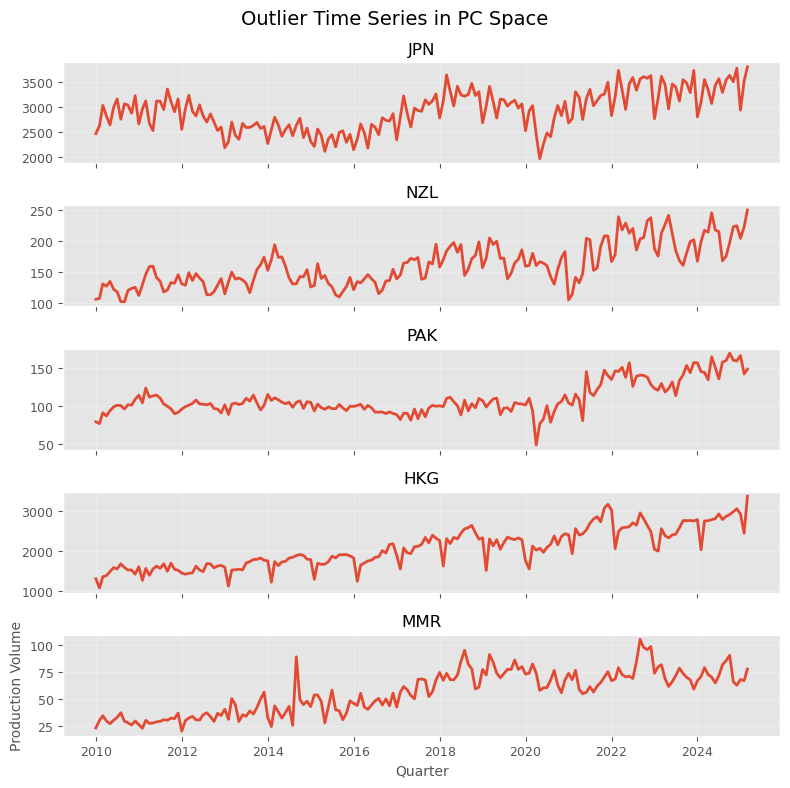


 Outlier Detection Complete!
• Identified 5 outlier crops
• Features used: seasonal_strength, trend, x_acf1, x_acf10, e_acf1, e_acf10, entropy
• PC1 explains 58.1% of variance
• PC1 + PC2 explain 78.2% of variance

Outlier var identified: ['JPN', 'NZL', 'PAK', 'HKG', 'MMR']


In [ ]:
def detect_outliers_with_pca(features_df, var_df,
                            feature_columns=None,
                            n_outliers=5,
                            plot_size=(8, 8),
                            scatter_size=(6, 4)):
    """
    Complete PCA-based outlier detection pipeline for time series var data.

    Parameters:
    -----------
    features_df : pd.DataFrame
        DataFrame containing time series features with 'unique_id' column
    var_df : pd.DataFrame
        Long format DataFrame with columns: ds, unique_id, y
    feature_columns : list, optional
        List of feature columns to use for PCA analysis
    n_outliers : int
        Number of top outliers to identify and plot
    plot_size : tuple
        Figure size for time series plots (width, height)
    scatter_size : tuple
        Figure size for PCA scatter plot (width, height)

    Returns:
    --------
    dict
        Dictionary containing:
        - 'outlier_ids': List of outlier unique_ids
        - 'pca_results': DataFrame with PCA components
        - 'feature_analysis': DataFrame with feature-based outlier analysis
        - 'pca_summary': PCA explained variance summary
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    # Default feature columns if not provided
    if feature_columns is None:
        feature_columns = ["seasonal_strength",
                            "trend",
                            "x_acf1",
                            "x_acf10",
                            "e_acf1",
                            "e_acf10",
                            "entropy"]

    print("Starting PCA-based Outlier Detection Pipeline")
    print("=" * 50)

    # Step 1: Prepare features for PCA
    print("1. Preparing features for PCA analysis...")
    feature_data = features_df[feature_columns].copy()
    unique_ids = features_df['unique_id'].copy()

    # Step 2: Standardize features
    print("2. Standardizing features...")
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_data)

    # Step 3: Perform PCA
    print("3. Performing PCA transformation...")
    pca = PCA()
    pca_components = pca.fit_transform(features_scaled)

    # Create PCA results DataFrame
    pca_results = pd.DataFrame(
        pca_components,
        columns=[f'PC{i+1}' for i in range(pca_components.shape[1])]
    )
    pca_results['unique_id'] = unique_ids.values

    # Step 4: Identify outliers
    print(f"4. Identifying top {n_outliers} outliers...")
    top_outliers = pca_results.nlargest(n_outliers, "PC1")
    outlier_ids = top_outliers["unique_id"].tolist()

    # Step 5: Display results
    print("\n PCA Analysis Results:")
    print("-" * 30)

    # PCA explained variance
    pca_summary = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
        'Explained_Variance_Ratio': pca.explained_variance_ratio_,
        'Cumulative_Variance_Ratio': np.cumsum(pca.explained_variance_ratio_)
    })

    print("PCA Explained Variance:")
    display(pca_summary.head())

    print(f"\nTop {n_outliers} Outlier var (by PC1):")
    display(top_outliers[['unique_id', 'PC1', 'PC2']])

    # Step 6: Create PCA scatter plot
    print("\n📈 Creating PCA scatter plot...")
    plt.figure(figsize=scatter_size)
    plt.scatter(pca_results['PC1'], pca_results['PC2'], alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA: Time Series Feature Space')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Step 7: Plot outlier time series
    print("\n📈 Plotting outlier time series...")
    fig, axes = plt.subplots(n_outliers, 1, sharex=True, figsize=plot_size)

    if n_outliers == 1:
        axes = [axes]

    for i, unique_id in enumerate(outlier_ids):
        subset = var_df[var_df["unique_id"] == unique_id]

        axes[i].plot(subset["ds"], subset["y"], linewidth=2)
        axes[i].set_title(unique_id, fontsize=12)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    plt.suptitle("Outlier Time Series in PC Space", fontsize=14)
    plt.xlabel("Quarter")
    plt.ylabel("Production Volume")
    plt.tight_layout()
    plt.show()

    # Step 9: Summary
    print("\n Outlier Detection Complete!")
    print("=" * 50)
    print(f"• Identified {len(outlier_ids)} outlier crops")
    print(f"• Features used: {', '.join(feature_columns)}")
    print(f"• PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
    print(f"• PC1 + PC2 explain {sum(pca.explained_variance_ratio_[:2]):.1%} of variance")

    # Return comprehensive results
    return {
        'outlier_ids': outlier_ids,
        'pca_results': pca_results,
        'pca_summary': pca_summary,
        'scaler': scaler,
        'pca_model': pca
    }

# Usage example:
df = DAT_Export.pivot_table(index='ds', columns='unique_id', values='y')

preprocessed_data = ts_feature_EXPORT.named_steps['preprocessor'].transform(df)
all_feat = ts_feature_EXPORT.named_steps['feature_extractor'].transform(preprocessed_data)

feature_columns = ["seasonal_strength","trend",
                    "x_acf1",
                    "x_acf10",
                    "e_acf1",
                    "e_acf10",
                    "entropy"]

results = detect_outliers_with_pca(
    features_df=all_feat,
    feature_columns=feature_columns,
    var_df=preprocessed_data,
    n_outliers=5
)

# Access results
outlier_var = results['outlier_ids']
pca_data = results['pca_results']

print(f"\nOutlier var identified: {outlier_var}")

### (b) Outlier Import

In [ ]:
df = DAT_Import.pivot_table(index='ds', columns='unique_id', values='y')


preprocessed_data = ts_feature_IMPORT.named_steps['preprocessor'].transform(df)
all_feat = ts_feature_IMPORT.named_steps['feature_extractor'].transform(preprocessed_data)

feature_columns = ["seasonal_strength","trend",
                    "x_acf1",
                    "x_acf10",
                    "e_acf1",
                    "e_acf10",
                    "entropy"]

results = detect_outliers_with_pca(
    features_df=all_feat,
    feature_columns=feature_columns,
    var_df=preprocessed_data,
    n_outliers=5
)

# Access results
outlier_var = results['outlier_ids']
pca_data = results['pca_results']

print(f"\nOutlier var identified: {outlier_var}")

Starting PCA-based Outlier Detection Pipeline
1. Preparing features for PCA analysis...
2. Standardizing features...
3. Performing PCA transformation...


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## 4.0 Forecasting

In [10]:
# AI Disclaimer: Claude Sonnet 4 was used to help refactor the code
# Concise Forecasting Pipeline for All Model Categories
from statsforecast import StatsForecast
from statsforecast.models import *
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from utilsforecast.feature_engineering import trend, fourier, pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# Setup
select = 'PHL'
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv', parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

display(DAT_Export.head())



,ds,unique_id,y
0,2010-01-01,AUS,618.538
1,2010-02-01,AUS,613.971
2,2010-03-01,AUS,699.770
3,2010-04-01,AUS,769.386
4,2010-05-01,AUS,829.484


In [13]:
train = DAT_Export[DAT_Export['unique_id'] == select]
HORIZON = 4
season_length = 4

print(f"Forecasting {select}: {train['ds'].min()} to {train['ds'].max()}")

# Prepare external features for regression models
features = [trend,
            partial(fourier, season_length=4, k=2)
            ]

df_train_aug, future_predictors = pipeline(train,
                                           features=features,
                                           freq="QS",
                                           h=HORIZON)

# Define all models in one place
def create_forecasting_pipeline():
    # StatsForecast models (Baseline + ETS + ARIMA)
    stats_models = [
        # Baseline
        Naive(), SeasonalNaive(season_length), RandomWalkWithDrift(), HistoricAverage(),
        # ETS
        AutoETS(season_length=season_length, model="AAA", alias="ETS_AAA"),
        AutoETS(season_length=season_length, model="MAM", alias="ETS_MAM"),
        # ARIMA
        AutoARIMA(season_length=season_length, alias="ARIMA"),
        # Dynamic Regression (ARIMA + external features)
        AutoARIMA(season_length=season_length, seasonal=False, alias="DynamicReg")
    ]

    # MLForecast models (Static Regression + ML)
    ml_models = [
        # Static Regression
        LinearRegression(), Ridge(),
        # Machine Learning
        RandomForestRegressor(n_estimators=50, random_state=42),
        lgb.LGBMRegressor(verbose=-1, n_estimators=50, random_state=42)
    ]

    return stats_models, ml_models

# Generate forecasts
def generate_all_forecasts():
    stats_models, ml_models = create_forecasting_pipeline()

    # StatsForecast models (regular)
    sf_regular = StatsForecast(stats_models[:-1], freq='QS', n_jobs=-1)
    fc_regular = sf_regular.forecast(h=HORIZON, df=train, fitted=True)

    # Dynamic regression model (needs external features)
    sf_dynamic = StatsForecast([stats_models[-1]], freq='QS')
    sf_dynamic.fit(df=df_train_aug)
    fc_dynamic = sf_dynamic.forecast(df=df_train_aug, h=HORIZON, X_df=future_predictors)

    # ML models
    mf = MLForecast(ml_models, freq="QS", lags=[4], target_transforms=[Differences([4])])
    mf.fit(df_train_aug, static_features = [])
    fc_ml = mf.predict(h=HORIZON, X_df=future_predictors)

    return fc_regular, fc_dynamic, fc_ml

# Execute pipeline
fc_regular, fc_dynamic, fc_ml = generate_all_forecasts()

# Combine all forecasts
all_forecasts = fc_regular.copy()
all_forecasts['DynamicReg'] = fc_dynamic['DynamicReg']
for col in fc_ml.columns:
    if col not in ['ds', 'unique_id']:
        all_forecasts[col] = fc_ml[col]

print(f"Generated forecasts for {len(all_forecasts.columns)-2} models")

# Display results
forecast_cols = [col for col in all_forecasts.columns if col not in ['ds', 'unique_id']]
result_df = all_forecasts[['ds'] + forecast_cols].set_index('ds')
print(f"\n=== FORECAST RESULTS ({len(forecast_cols)} models) ===")
display(result_df.round(2))

Forecasting PHL: 2010-01-01 00:00:00 to 2025-03-01 00:00:00
Generated forecasts for 12 models

=== FORECAST RESULTS (12 models) ===


,Naive,SeasonalNaive,RWD,HistoricAverage,ETS_AAA,ETS_MAM,ARIMA,DynamicReg,LinearRegression,Ridge,RandomForestRegressor,LGBMRegressor
ds,,,,,,,,,,,,
2025-04-01,378.1,330.50,379.27,265.83,361.07,356.36,371.05,362.97,361.05,362.28,389.78,366.49
2025-07-01,378.1,371.47,380.44,265.83,375.51,376.58,350.77,374.58,370.92,370.39,373.28,382.06
2025-10-01,378.1,362.64,381.62,265.83,373.66,371.67,344.61,372.85,366.58,366.46,361.87,361.52
2026-01-01,378.1,378.10,382.79,265.83,378.53,380.59,355.24,379.08,365.14,365.69,368.83,375.27


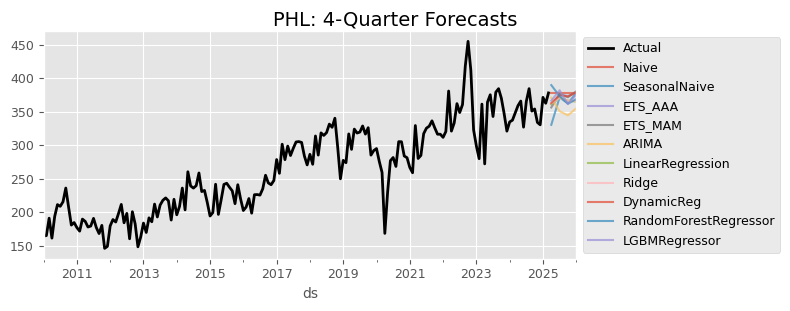

In [15]:
# Visualization
model_categories = {
    'Baseline': ['Naive', 'SeasonalNaive', 'RandomWalkWithDrift'],
    'ETS & ARIMA': ['ETS_AAA', 'ETS_MAM', 'ARIMA'],
    'Regression': ['LinearRegression', 'Ridge', 'DynamicReg'],
    'ML': ['RandomForestRegressor', 'LGBMRegressor']
}

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

train.plot(x='ds', y='y', ax=ax, color='black', linewidth=2, label='Actual')

for idx, (category, models) in enumerate(model_categories.items()):
    for model in models:
        if model in all_forecasts.columns:
            all_forecasts.plot(x='ds', y=model, ax=ax, alpha=0.7, label=model)

    #ax.set_title(f'{category} Models')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.suptitle(f'{select}: 4-Quarter Forecasts', fontsize=14, y=1.02)
plt.show()


### Cross-validation

In [21]:
train

,ds,unique_id,y
1830,2010-01-01,PHL,164.515
1831,2010-02-01,PHL,165.051
1832,2010-03-01,PHL,191.054
1833,2010-04-01,PHL,161.294
1834,2010-05-01,PHL,193.668
...,...,...,...
2008,2024-11-01,PHL,334.019
2009,2024-12-01,PHL,330.503
2010,2025-01-01,PHL,371.471
2011,2025-02-01,PHL,362.641


In [42]:
# Generate forecasts
def generate_all_forecasts_TSCV(train = [] ,
                                df_train_aug = [],
                                step = 4,
                                HORIZON=4*2):
    from functools import partial
    from utilsforecast.evaluation import evaluate
    from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

    def mape(df, models, id_col = "unique_id", target_col = "y"):
        df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
        df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100

        return df_mape

    metrics = [rmse, mae, mape, partial(mase, seasonality=4), partial(rmsse, seasonality=4)]

    stats_models, ml_models = create_forecasting_pipeline()

    # StatsForecast models (regular)
    sf_regular = StatsForecast(stats_models[:-1], freq='MS', n_jobs=-1)
    fc_regular_cv = sf_regular.cross_validation(df=train, h=HORIZON, step_size=step)
    fc_regular_eval = evaluate(fc_regular_cv.drop('cutoff', axis=1), metrics=metrics, train_df=train).drop('unique_id',axis=1).set_index('metric')

    # Dynamic regression model (needs external features)
    sf_dynamic = StatsForecast([stats_models[-1]], freq='MS')
    fc_dynamic_cv = sf_dynamic.cross_validation(df=df_train_aug, h=HORIZON,  step_size=step)
    fc_dynamic_eval = evaluate(fc_dynamic_cv.drop('cutoff', axis=1), metrics=metrics, train_df=train).drop('unique_id',axis=1).set_index('metric')

    # ML models
    mf = MLForecast(ml_models, freq="MS", lags=[4], target_transforms=[Differences([4])])

    mf_cv = mf.cross_validation(
        df=df_train_aug,
        h=HORIZON,
        n_windows = 3,
        step_size=step,
        static_features = [])
    fc_ml_eval = evaluate(mf_cv.drop('cutoff', axis=1), metrics=metrics,        train_df=train).drop('unique_id',axis=1).set_index('metric')

    output = (fc_regular_eval
             .join(fc_dynamic_eval, how='inner')
             .join(fc_ml_eval, how='inner')
             .T
             .sort_values(by='mae', ascending=True)
             .round(2))

    entry = {}
    entry['unique_id'] = train.unique_id.unique()[0]
    entry['Best Method'] = output.index.tolist()[0]
    entry.update(output.iloc[0,:].to_dict())

    return output, entry

HORIZON = 3*2
features = [trend,
            partial(fourier, season_length=4, k=2)
            ]

df_train_aug, future_predictors = pipeline(train,
                                           features=features,
                                           freq="MS",
                                           h=HORIZON)

results, entry = generate_all_forecasts_TSCV(train = train ,
                                df_train_aug = df_train_aug,
                                step = 3, HORIZON=HORIZON)
results

metric,rmse,mae,mape,mase,rmsse
DynamicReg,15.64,10.02,2.99,0.33,0.39
ETS_AAA,16.92,12.78,3.75,0.43,0.43
ETS_MAM,18.48,12.81,3.79,0.43,0.47
RWD,16.65,14.72,4.18,0.49,0.42
ARIMA,20.51,16.41,4.78,0.55,0.52
Naive,18.30,16.66,4.68,0.56,0.46
Ridge,23.96,19.46,5.57,0.65,0.60
RandomForestRegressor,23.88,19.50,5.48,0.65,0.60
LinearRegression,24.11,20.41,5.85,0.68,0.61
LGBMRegressor,28.21,24.58,7.00,0.82,0.71


### END

In [ ]:
#arrange dates

DAT_Import.pivot(index='ds', columns='unique_id', values='y')
DAT_Import['ds']

0        1/1/2010
1        2/1/2010
2        3/1/2010
3        4/1/2010
4        5/1/2010
          ...    
3289    11/1/2024
3290    12/1/2024
3291     1/1/2025
3292     2/1/2025
3293     3/1/2025
Name: ds, Length: 3294, dtype: object

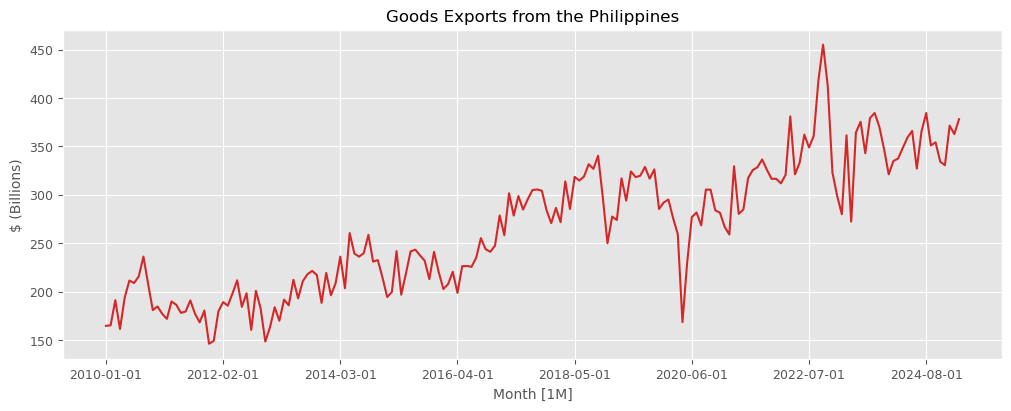

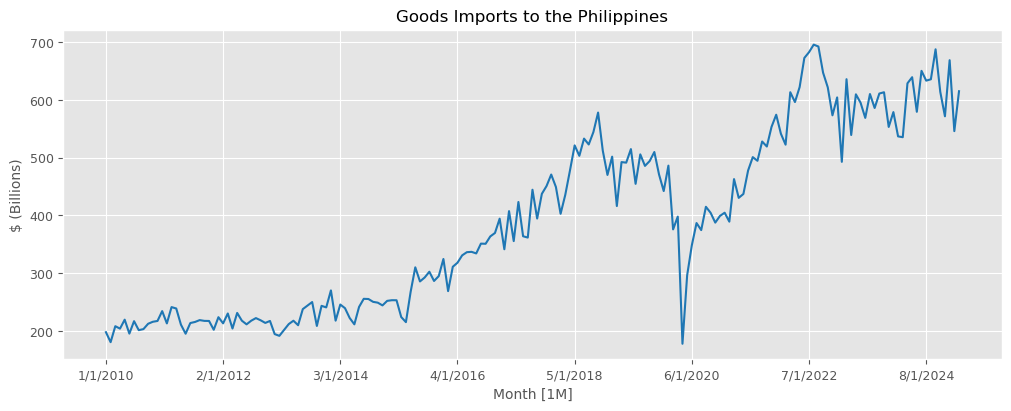

In [ ]:
plot_series(DAT_Export[DAT_Export['unique_id'] == 'PHL'],
            time_col='ds',
            target_col='y',
            xlabel='Month [1M]',
            ylabel='$ (Billions)',
            color='tab:red',
            title='Goods Exports from the Philippines')

plot_series(DAT_Import[DAT_Import['unique_id'] == 'PHL'],
            time_col='ds',
            target_col='y',
            xlabel='Month [1M]',
            ylabel='$ (Billions)',
            color='tab:blue',
            title='Goods Imports to the Philippines')

### TRAIN/TEST SPLIT
DAT_Export.query('ds < "2024-01-01"').to_csv('./data/TRAIN_Export.csv')
DAT_Export.query('ds >= "2024-01-01"').to_csv('./data/TEST_Export.csv')

DAT_Import.query('ds < "2024-01-01"').to_csv('./data/TRAIN_Import.csv')
DAT_Import.query('ds >= "2024-01-01"').to_csv('./data/TEST_Import.csv')


### 1.1 EDA: ACF Features of Imports and Exports cross-country

In [ ]:
from tsfeatures import *
from joblib import delayed, Parallel

summary_stats = tsfeatures(DAT_Export, freq=12, features=[statistics], scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].sort_values(by='median', ascending=False)

all_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst,
]
cc_order = ['PHL','USA','HKG','JPN','CHN','SGP','KOR','IND','THA','MMR','VNM','TWN']
#selected metrics
metrics = ['unique_id',
           'trend','seasonal_strength',
           'x_acf1','x_acf10',
           'e_acf1','e_acf10',
           'entropy',
           'linearity',
           'nonlinearity']


Input = [('EXPORT', DAT_Export),
         ('IMPORT', DAT_Import)]

def proc_tsfeatures(tag, DAT_IN):
    ''' The function computes time series features for a given dataset.
    '''

    all_feat = tsfeatures(DAT_IN, freq=12, features=all_features)
    (all_feat[metrics]
        .set_index('unique_id')
        .sort_values(by='trend', ascending=False)
        .T
        ).to_csv(f'./results/annex_{tag}_tsfeatures_all.csv')
    (all_feat[metrics]
        .set_index('unique_id')
        .sort_values(by='trend', ascending=False)
        .T
        )[cc_order].to_csv(f'./results/annex_{tag}_tsfeatures_select.csv')

    return

#include njobs
Parallel(n_jobs=-1, verbose=10)(delayed(proc_tsfeatures)(tag, DAT_IN) for tag, DAT_IN in Input)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   25.9s finished


[None, None]

### Decomposition (STL)
We visualize the components of the series.

* Does the amplitude of signal change with levels?
* Do we need to do log transform?
* Is there seasonality in the data?

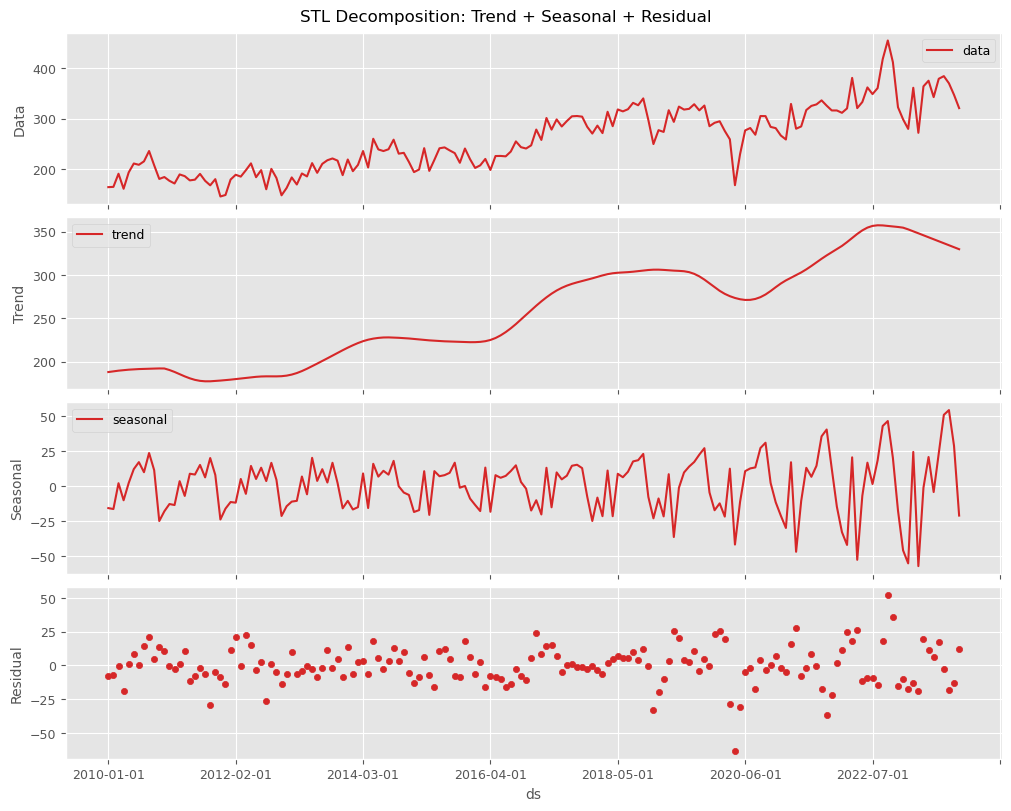

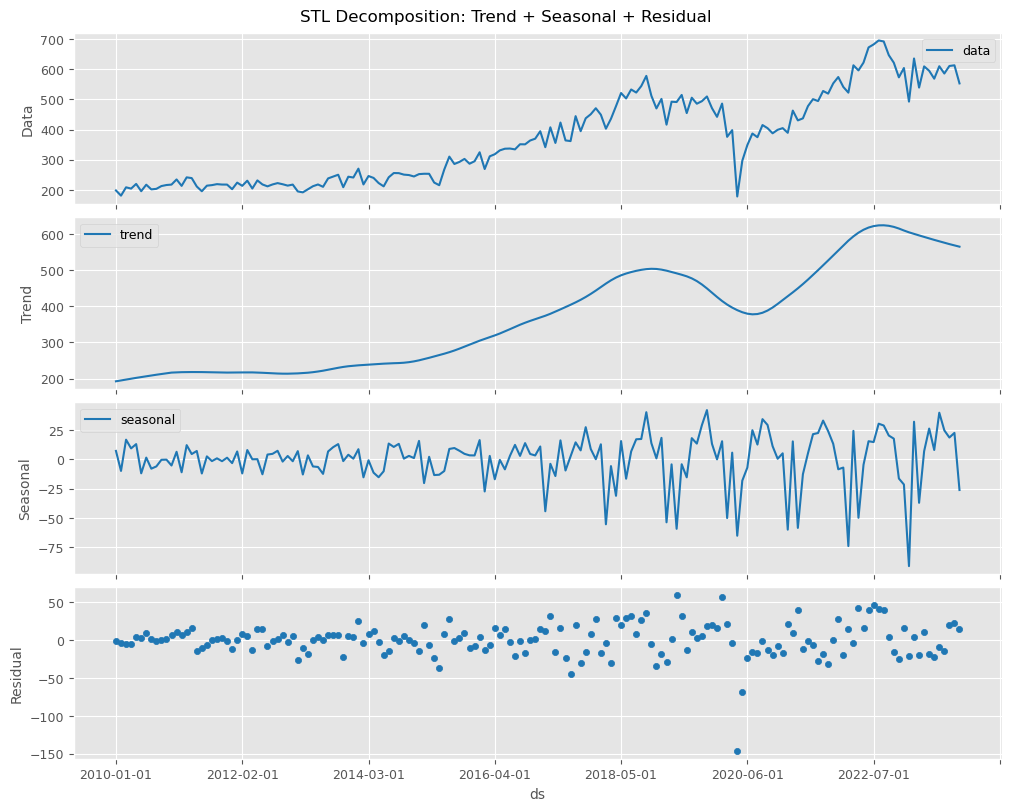

In [ ]:
#import STL
DAT_Export = pd.read_csv('./data/TRAIN_Export.csv', parse_dates=True)
DAT_Import = pd.read_csv('./data/TRAIN_Import.csv', parse_dates=True)



PH_EXPORT = DAT_Export[DAT_Export['unique_id'] == 'PHL']
PH_IMPORT = DAT_Import[DAT_Import['unique_id'] == 'PHL']
PERIODICITY = 12 # set as data is monthly

def STL_decompose(df=PH_EXPORT, period=PERIODICITY, color='tab:red', showFig=True):
    '''
    Decomposes the time series data using STL.

    Parameters
    ----------
    df : DataFrame
        The DataFrame containing the time series data.
    period : int
        The periodicity of the data (e.g., 12 for monthly data).

    Returns
    -------
    res : STL result object
        Contains the trend, seasonal, and residual components.
    '''
    from statsmodels.tsa.seasonal import STL
    import seaborn as sns

    res = STL(df['y'], period=PERIODICITY).fit()
    df_dcmp = pd.DataFrame({
        'ds': df["ds"],
        'data': df["y"],
        'trend': res.trend,
        'seasonal': res.seasonal,
        "resid": res.resid
    }).reset_index(drop=True)

    if showFig:
        fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))
        df_dcmp.plot(x='ds', y='data', ax=axes[0], color=color)
        df_dcmp.plot(x='ds', y='trend', ax=axes[1], color=color)
        df_dcmp.plot(x='ds', y='seasonal', ax=axes[2], color=color)
        df_dcmp.plot(x='ds', y='resid', ax=axes[3], color=color, kind='scatter')
        axes[0].set_ylabel('Data')
        axes[1].set_ylabel('Trend')
        axes[2].set_ylabel('Seasonal')
        axes[3].set_ylabel('Residual')
        fig.suptitle("STL Decomposition: Trend + Seasonal + Residual")
        plt.show()

    return df_dcmp

STL_decompose(df=PH_EXPORT, period=PERIODICITY, color='tab:red', showFig=True);
STL_decompose(df=PH_IMPORT, period=PERIODICITY, color='tab:blue', showFig=True);

#### insight on the decomposition

The seasonal component shows that varying amplitude (increasing with levels).
This requires us to apply log transform to the series to suppress variations in amplitude



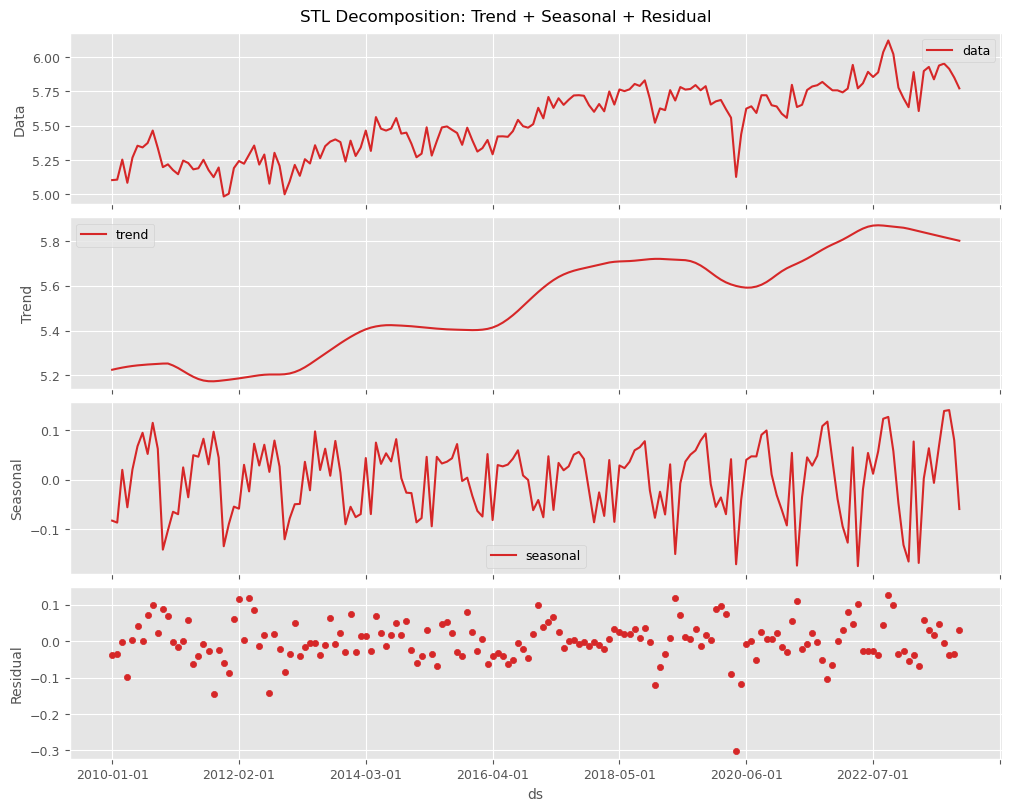

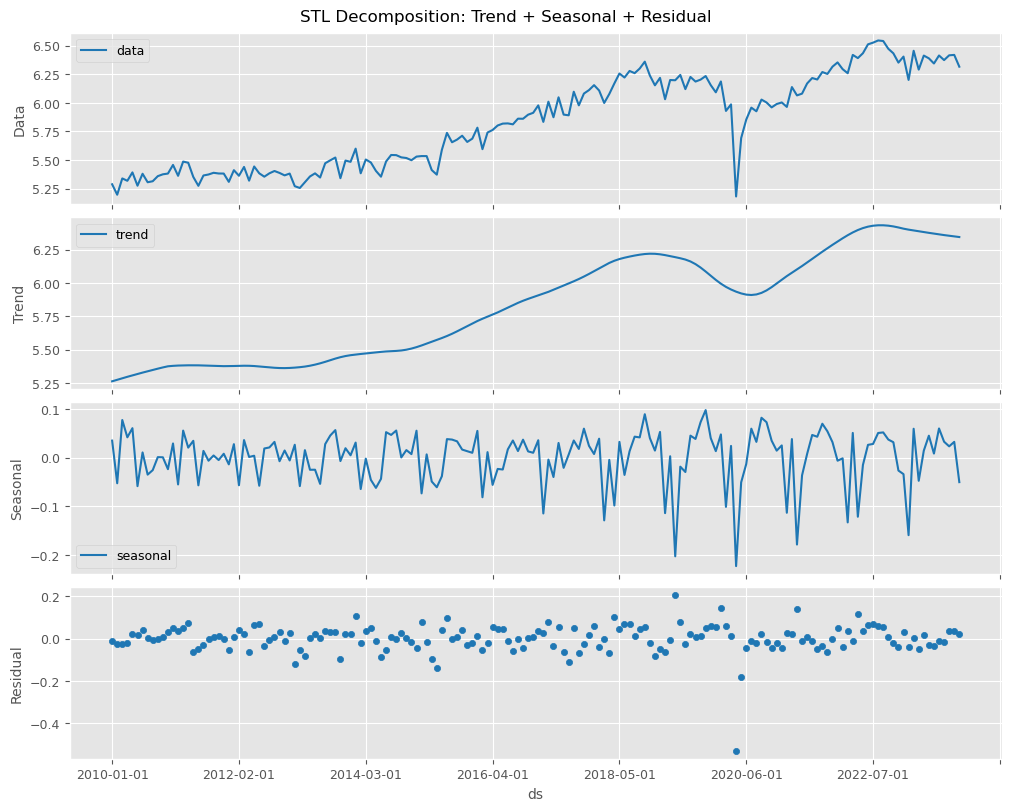

In [ ]:
PH_EXPORTlog = DAT_Export[DAT_Export['unique_id'] == 'PHL'].copy()
PH_IMPORTlog = DAT_Import[DAT_Import['unique_id'] == 'PHL'].copy()

PH_EXPORTlog['y'] = np.log(PH_EXPORTlog['y'].to_numpy())
PH_IMPORTlog['y'] = np.log(PH_IMPORTlog['y'].to_numpy())

PERIODICITY = 12 # set as data is monthly

PH_Exportlog_dcmp = STL_decompose(df=PH_EXPORTlog, period=PERIODICITY, color='tab:red', showFig=True);
PH_Importlog_dcmp = STL_decompose(df=PH_IMPORTlog, period=PERIODICITY, color='tab:blue', showFig=True);

PH_Exportlog_dcmp['unique_id'] = 'PHL'
PH_Importlog_dcmp['unique_id'] = 'PHL'

In [ ]:
#Apply Naive model to decomposed series using STATS forecast
from statsforecast import StatsForecast
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mase, mape as _mape

from statsforecast.models import (
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

#input additional benchmark models here
sf_trend = StatsForecast(
    models = [RandomWalkWithDrift(),
              HistoricAverage(),
              Naive()],
    freq = 'MS'
)


sf_seasonal = StatsForecast(
    models = [SeasonalNaive(12)],
    freq = 'MS'
)

df_train_trend = pd.DataFrame({'ds':PH_Exportlog_dcmp['ds'],
                               'y': PH_Exportlog_dcmp['trend'],
                               'unique_id': PH_Exportlog_dcmp['unique_id']})

df_train_seasonal = pd.DataFrame({'ds':PH_Exportlog_dcmp['ds'],
                               'y': PH_Exportlog_dcmp['seasonal'],
                               'unique_id': PH_Exportlog_dcmp['unique_id']})


inputs = [('trend', 3, df_train_trend, sf_trend),
          ('seasonal', 3, df_train_seasonal, sf_seasonal),
          ('trend', 6, df_train_trend, sf_trend),
          ('seasonal', 6, df_train_seasonal, sf_seasonal),
          ('trend', 9, df_train_trend, sf_trend),
          ('seasonal', 9, df_train_seasonal, sf_seasonal),
          ('trend', 12, df_train_trend, sf_trend),
          ('seasonal', 12, df_train_seasonal, sf_seasonal),
          ('trend', 15, df_train_trend, sf_trend),
          ('seasonal', 15, df_train_seasonal, sf_seasonal)]

results = []
for tag, h, df, sf in inputs:
    df_f = sf.cross_validation(df=df,
                                     h=h,
                                     n_windows=10,
                                     step_size=1) # one-step rolling window forecasts
    df_eval = evaluate(df_f.drop("cutoff", axis=1), metrics=[mae, rmse, _mape,
                                                            partial(mase, seasonality=1)],
                                                            train_df=df)
    out = {}
    out['tag'] = tag
    out['horizon'] = h
    out['eval_cv'] = df_eval.set_index('metric').T.drop('unique_id').sort_values(by='mae')

    results.append(out)

results


[{'tag': 'trend',
  'horizon': 3,
  'eval_cv': metric             mae   rmse   mape    mase
  Naive             0.01  0.011  0.002   1.466
  RWD              0.018   0.02  0.003   2.564
  HistoricAverage  0.325  0.325  0.056  46.117},
 {'tag': 'seasonal',
  'horizon': 3,
  'eval_cv': metric           mae   rmse   mape   mase
  SeasonalNaive  0.017  0.019  1.377  0.256},
 {'tag': 'trend',
  'horizon': 6,
  'eval_cv': metric             mae   rmse   mape    mase
  Naive            0.016  0.019  0.003    2.29
  RWD               0.03  0.034  0.005    4.29
  HistoricAverage  0.338  0.339  0.058  48.098},
 {'tag': 'seasonal',
  'horizon': 6,
  'eval_cv': metric           mae  rmse   mape   mase
  SeasonalNaive  0.017  0.02  1.388  0.269},
 {'tag': 'trend',
  'horizon': 9,
  'eval_cv': metric             mae   rmse   mape    mase
  Naive            0.019  0.023  0.003    2.67
  RWD              0.039  0.046  0.007   5.563
  HistoricAverage  0.352  0.353   0.06  50.016},
 {'tag': 'seasonal',


<Axes: xlabel='horizon'>

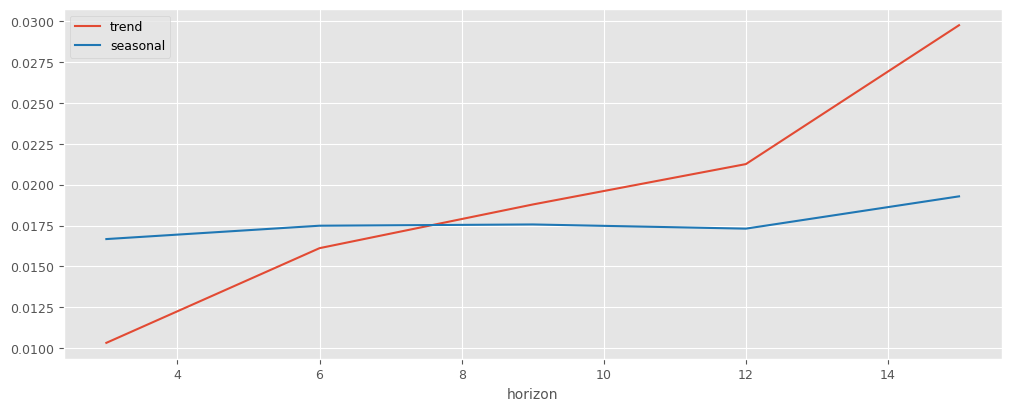

In [ ]:
#collect results

df = pd.DataFrame([])
for x in results:
    temp = x['eval_cv'].copy()
    temp['tag'] = x['tag']
    temp['horizon'] = x['horizon']

    df = pd.concat([df,temp],axis=0)

df.reset_index()

fig, ax = plt.subplots()
df.query('index == "Naive"').plot(x='horizon',y='mae',
                                  label='trend',
                                  ax= ax)
df.query('index == "SeasonalNaive"').plot(x='horizon',
                                          y='mae',
                                          label='seasonal',
                                          ax=ax,color='tab:blue')

#### Insights on Errors of Naive benchmark models
* The best baseline models are the naive (for trend) and seasonal naive (for seasonal component)
* Errors for seasonal Naive model were stable around 0.0175 across different forecast horizons
* Errors for the trend increased from 0.01 to 0.02 from 3 to 12 month forecast horizons.

### ETS

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS, SimpleExponentialSmoothingOptimized

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mase, mape as _mape

sf = StatsForecast(
    models=[
        AutoETS(season_length=1, model="ANN", alias="SES"),
        AutoETS(season_length=1, model="AAN", alias="Holt"),
        AutoETS(season_length=1, model="AAN", damped=True, phi=0.9, alias="Damped"),
    ],
    freq=1,
)

df_f = sf.cross_validation(df=df_www, h=10, n_windows=10, step_size=1) # one-step rolling window forecasts

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

df_eval = evaluate(df_f.drop("cutoff", axis=1), metrics=[mae, rmse, mape, partial(mase, seasonality=1)], train_df=df_www)
df_eval.set_index('metric').T.drop('unique_id').sort_values(by='mae')

### Statistics of the data

In [ ]:
#ACF features
acf_feat = tsfeatures(DAT_Export, freq=12, features=[acf_features])
acf_feat

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,AUS,0.954,7.547,-0.339,0.382,-0.569,0.706,0.743
1,CHN,0.896,6.200,-0.308,0.159,-0.523,0.334,0.754
2,HKG,0.843,5.183,-0.395,0.209,-0.620,0.526,0.712
3,IDN,0.939,6.855,-0.419,0.279,-0.660,0.606,0.672
4,IND,0.908,6.553,-0.455,0.378,-0.648,0.606,0.667
5,JPN,0.682,3.486,-0.340,0.853,-0.480,1.010,0.637
6,KOR,0.904,6.178,-0.392,0.456,-0.594,0.702,0.608
7,MMR,0.856,5.713,-0.295,0.234,-0.564,0.498,0.680
8,MYS,0.923,6.787,-0.438,0.705,-0.596,0.925,0.686
9,NZL,0.806,3.588,-0.116,0.215,-0.456,0.413,0.593


In [ ]:
stl_feat = tsfeatures(DAT_Export, freq=12, features=[stl_features])
stl_feat

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,AUS,1,12,0.984,3.646e-08,10.864,4.629,0.452,0.443,0.598,6,2
1,CHN,1,12,0.979,6.074e-08,12.174,2.794,0.141,0.229,0.832,12,2
2,HKG,1,12,0.961,2.091e-07,11.878,0.947,0.150,0.164,0.790,9,2
3,IDN,1,12,0.971,1.120e-07,10.405,5.963,-0.002,0.059,0.426,8,2
4,IND,1,12,0.960,5.009e-07,11.406,3.778,0.232,0.237,0.463,3,11
5,JPN,1,12,0.930,3.841e-07,7.207,5.051,0.329,0.332,0.811,12,1
6,KOR,1,12,0.962,1.156e-07,11.502,2.814,0.075,0.072,0.528,12,1
7,MMR,1,12,0.886,2.959e-06,11.069,-2.300,0.145,0.208,0.340,10,6
8,MYS,1,12,0.973,7.594e-08,11.509,4.748,0.089,0.187,0.510,3,2
9,NZL,1,12,0.914,6.425e-07,10.325,1.851,0.378,0.424,0.722,5,8


Text(0, 0.5, 'Seasonal Strength')

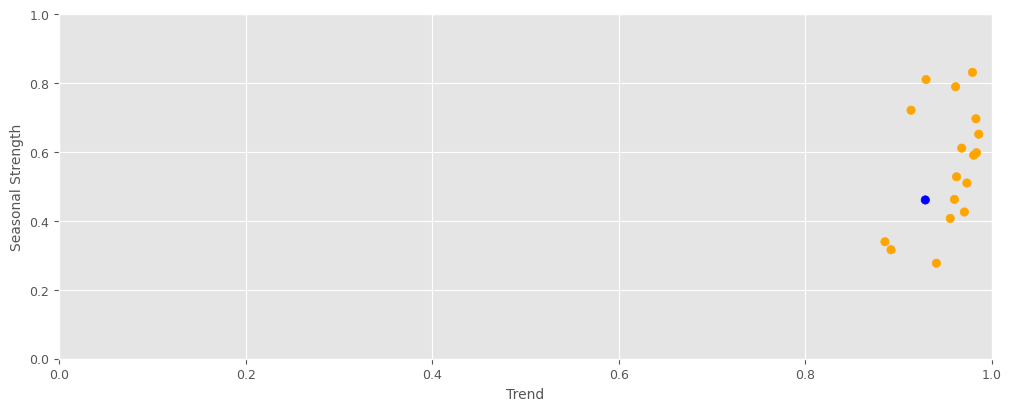

In [ ]:
fig, ax = plt.subplots()
ax.scatter(stl_feat['trend'], stl_feat['seasonal_strength'], color=stl_feat['unique_id'].apply(lambda x: 'blue' if x == 'PHL' else 'orange'))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Trend')
ax.set_ylabel('Seasonal Strength')

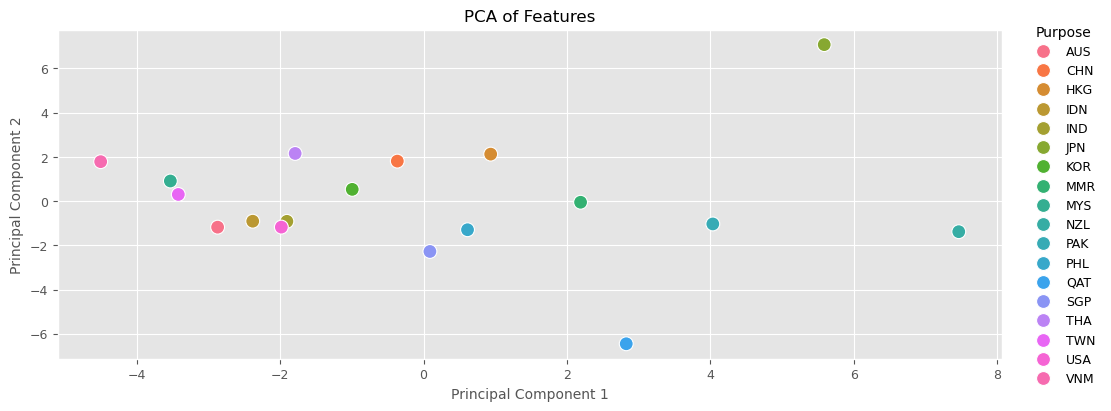

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = all_feat.columns.drop(["unique_id","arch_acf","garch_acf","arch_r2","garch_r2","series_length"])
X = all_feat[features]
y = all_feat["unique_id"]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plotting the first two PCA components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["purpose"] = y

fig, ax = plt.subplots()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="purpose", s=100, ax=ax)
ax.set_title("PCA of Features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Purpose", loc="center left", bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0)
plt.show()

### STL decomposition

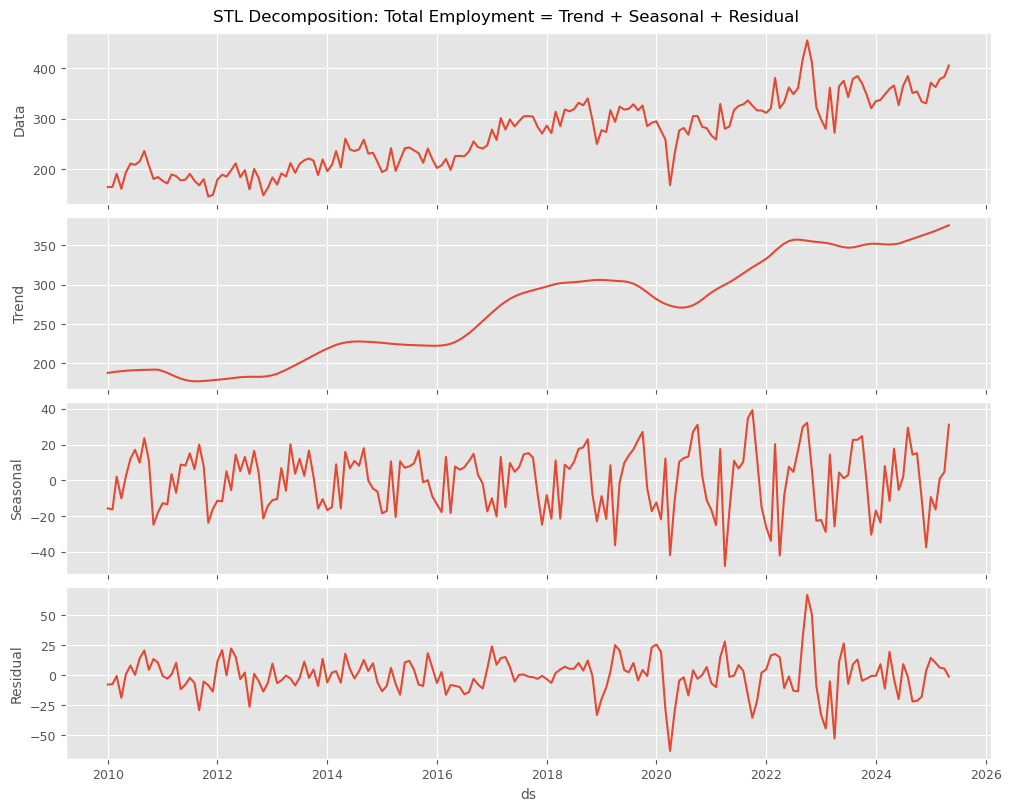

In [ ]:
PHL_export = DAT_Export[DAT_Export['unique_id'] == 'PHL'].dropna().copy()

res = STL(PHL_export['y'], period=12).fit()

df_dcmp = pd.DataFrame({
    'ds': PHL_export["ds"],
    'data': PHL_export["y"],
    'trend': res.trend,
    'seasonal': res.seasonal,
    "resid": res.resid
}).reset_index(drop=True)

df_dcmp.head()

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))
sns.lineplot(data=df_dcmp, x='ds', y='data', ax=axes[0])
sns.lineplot(data=df_dcmp, x='ds', y='trend', ax=axes[1])
sns.lineplot(data=df_dcmp, x='ds', y='seasonal', ax=axes[2])
sns.lineplot(data=df_dcmp, x='ds', y='resid', ax=axes[3])
axes[0].set_ylabel('Data')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')
fig.suptitle("STL Decomposition: Total Employment = Trend + Seasonal + Residual")
plt.show()

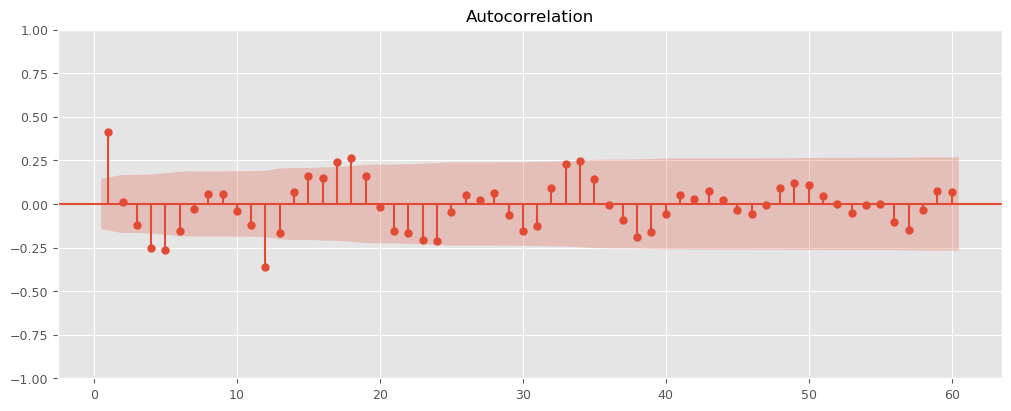

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df_dcmp['resid'], zero=False, lags=60, ax=ax)
plt.show()

#### insights:

* There is a strong trend in the data series (range = 200 to 350)
* seasonal and residual patterns appear to be minimal (range = -50 to 50)


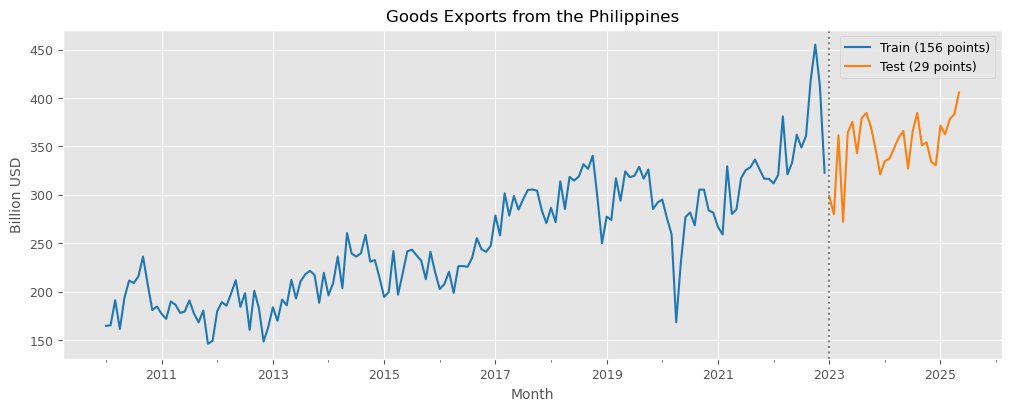

In [ ]:
df = PHL_export.copy().dropna().sort_values(by='ds', ascending=True)
df['y'] = df['y'].astype(float)

# Single train-test split!
df_train = df.query("ds.dt.year <= 2022")
df_test = df.query("ds.dt.year > 2022")

fig, ax = plt.subplots()
df_train.plot(ax=ax, x='ds', y='y', color='tab:blue', legend=False)
df_test.plot(ax=ax, x='ds', y='y', color='tab:orange', legend=False)
ax.set_title("Goods Exports from the Philippines")
ax.set_xlabel("Month")
ax.set_ylabel("Billion USD")
plt.axvline(x=df_test['ds'].iloc[0], color='grey', linestyle='dotted')
plt.legend([f'Train ({len(df_train)} points)', f'Test ({len(df_test)} points)'])
plt.autoscale()
plt.show()

## Baseline Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

In [ ]:
sf = StatsForecast(
    models=[RandomWalkWithDrift(), HistoricAverage(), Naive(), SeasonalNaive(12)], # 4 baseline methods
    freq="MS"
)

df_f = sf.forecast(h=len(df_test), df=df_train) # h=10
df_f = pd.merge(df_test, df_f, on=['ds', 'unique_id']) # append ground truth "y"
df_f



,ds,unique_id,y,RWD,HistoricAverage,Naive,SeasonalNaive
0,2023-01-01,PHL,298.851,323.814,251.572,322.793,311.774
1,2023-02-01,PHL,279.906,324.835,251.572,322.793,320.506
2,2023-03-01,PHL,361.397,325.856,251.572,322.793,380.927
3,2023-04-01,PHL,272.147,326.878,251.572,322.793,321.060
4,2023-05-01,PHL,364.258,327.899,251.572,322.793,333.148
5,2023-06-01,PHL,375.375,328.920,251.572,322.793,362.094
6,2023-07-01,PHL,342.881,329.941,251.572,322.793,348.840
7,2023-08-01,PHL,379.183,330.962,251.572,322.793,360.693
8,2023-09-01,PHL,384.462,331.983,251.572,322.793,417.995
9,2023-10-01,PHL,370.253,333.005,251.572,322.793,455.113


In [ ]:
# raw errors
pd.DataFrame({
    "e_RWD": df_f["y"] - df_f["RWD"],
    "e_HistoricAverage": df_f["y"] - df_f["HistoricAverage"],
    "e_Naive": df_f["y"] - df_f["Naive"],
    "e_SeasonalNaive": df_f["y"] - df_f["SeasonalNaive"],
})

from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

df_eval = evaluate(df_f, metrics=[rmse, mae, mape, partial(mase, seasonality=4), partial(rmsse, seasonality=4)], train_df=df_train) # mase uses snaive as scaler
df_eval.set_index('metric').T.drop('unique_id').sort_values(by='mae')

metric,rmse,mae,mape,mase,rmsse
RWD,30.443,25.901,7.391,0.94,0.865
Naive,41.732,36.814,10.304,1.336,1.186
SeasonalNaive,45.636,37.503,10.684,1.361,1.297
HistoricAverage,104.34,99.814,27.811,3.621,2.965


/var/folders/9y/vgkg6w9144v1vtff9_5ft2fw0000gn/T/ipykernel_9626/735488974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["resid"] = df_train["y"].diff().values # easy trick to get Naive forecasts/residuals


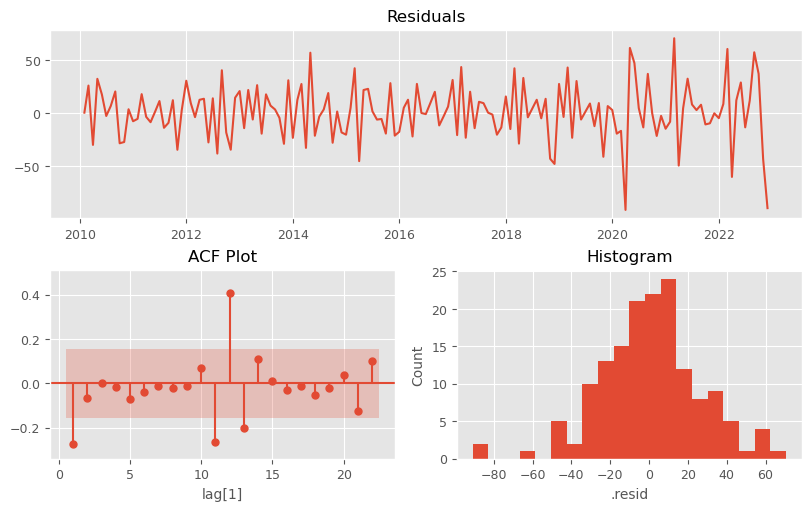

In [ ]:
fig = plt.figure(figsize=(8, 5))
df_train["resid"] = df_train["y"].diff().values # easy trick to get Naive forecasts/residuals

ax1 = fig.add_subplot(2, 2, (1, 2))
ax1.plot(df_train['ds'], df_train["resid"])
ax1.set_title("Residuals")

ax2 = fig.add_subplot(2, 2, 3)
plot_acf(df_train["resid"].dropna(), ax=ax2, zero=False,
  bartlett_confint=False, auto_ylims=True)
ax2.set_title("ACF Plot")
ax2.set_xlabel('lag[1]')

ax3 = fig.add_subplot(2, 2, 4)
ax3.hist(df_train["resid"], bins=20)
ax3.set_title("Histogram")
ax3.set_xlabel(".resid")
ax3.set_ylabel("Count")

plt.show()